In [1]:
import pandas as pd
import numpy as np
import datetime
import ast
import warnings
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency, chi2,ttest_ind
from ast import literal_eval
import string

warnings.filterwarnings('ignore')


In [2]:
ratingsdf = pd.read_csv('ratings.csv')
ratingsdf2 = ratingsdf.groupby('movieId', as_index = False).agg({'userId': 'count','rating':'mean'})
ratingsdf2.rename(columns ={'userId':'rating_count','rating':'rating_average'}, inplace= True)


In [3]:
# Aggregate tags and convert timestamps again.


tagsdf = pd.read_csv('tags.csv')
tagsdf.timestamp = pd.to_datetime(tagsdf.timestamp, unit = 's')
tagsdf.tag = tagsdf.tag.astype(str)
tagsdf['tag'] = tagsdf['tag'].str.replace(r'[^\w\s]+', '')
tagsdf.tag = tagsdf.tag.replace("  ", " ", regex = True)
tagsdf.tag = tagsdf.tag.replace("   ", " ",regex = True)
tagsdf.tag = tagsdf.tag.str.lower()
tagsdf = tagsdf.drop_duplicates(subset = 'tag')
tagsdf.timestamp = tagsdf.timestamp.dt.strftime('%Y-%m-%d')
tagsdf = tagsdf[(tagsdf.tag.notnull()) &(tagsdf.timestamp.notnull())]
tagsdf = tagsdf.groupby(['movieId'], as_index = False).agg({'tag':lambda x: ' '.join(x)})
tagsdf.tag = tagsdf.tag.apply(lambda x: [x])
tagsdf




movieId                                                tag
0            1  [watched computer animation disney animated fe...
1            2  [board game childhood recaptured game herds of...
2            3  [old people that is actually funny sequel feve...
3            5  [it thought it was funny but it wasnt watched ...
4            6  [michael mann val kilmer ending lame professio...
...        ...                                                ...
10373   130984                            [el santo transylvania]
10374   131011                            [good cop manslaughter]
10375   131031                                  [female football]
10376   131082                                   [yoshitomo nara]
10377   131258                                    [bandits whale]

[10378 rows x 2 columns]

In [4]:
# Retrieve name tags. This will be used for later analysis.
#def name(tag):
#    if tag[0].isupper() is True:
#        return tag.lower().replace(" ",'')
#    else:
#        return tag

#tagsdf.tag = tagsdf.tag.apply(name)

In [5]:
moviesdf = pd.read_csv('movies.csv')
moviesdf['genres'] = moviesdf.genres.str.split("|")
moviesdf = moviesdf.drop(columns = 'title')
linksdf = pd.read_csv('links.csv')
moviesdf = moviesdf.merge(linksdf, how = 'left', on ='movieId')
moviesdf.tmdbId = moviesdf.tmdbId.fillna(0)
moviesdf.tmdbId = moviesdf.tmdbId.astype(int)
moviesdf.movieId.duplicated().any()

False

In [6]:
md = pd.read_csv('movies_metadata.csv', low_memory = False)
md = md[['id','title','release_date','budget','original_language','popularity','production_companies',
   'revenue','runtime','overview']]
md[md.title.isnull()]
md['production_companies'] = md['production_companies'].fillna('[]').apply(ast.literal_eval)
md['production_companiesn'] = md['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)
md['production_companiesid'] = md['production_companies'].apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else np.nan)
md.drop(columns = ['production_companies'],index = [19730,29503,19729,35586,35587,29502], inplace = True)
md.rename(columns= {'production_companiesn':'production_companies', 'id':'tmdbId'}, inplace=True)
md.tmdbId = md.tmdbId.astype(int)
md

tmdbId                        title release_date    budget  \
0         862                    Toy Story   1995-10-30  30000000   
1        8844                      Jumanji   1995-12-15  65000000   
2       15602             Grumpier Old Men   1995-12-22         0   
3       31357            Waiting to Exhale   1995-12-22  16000000   
4       11862  Father of the Bride Part II   1995-02-10         0   
...       ...                          ...          ...       ...   
45461  439050                       Subdue          NaN         0   
45462  111109          Century of Birthing   2011-11-17         0   
45463   67758                     Betrayal   2003-08-01         0   
45464  227506             Satan Triumphant   1917-10-21         0   
45465  461257                     Queerama   2017-06-09         0   

      original_language popularity      revenue  runtime  \
0                    en  21.946943  373554033.0     81.0   
1                    en  17.015539  262797249.0    104.0   
2                    en    11.7129          0.0    101.0   
3                    en   3.859495   81452156.0    127.0   
4                    en   8.387519   76578911.0    106.0   
...                 ...        ...          ...      ...   
45461                fa   0.072051          0.0     90.0   
45462                tl   0.178241          0.0    360.0   
45463                en   0.903007          0.0     90.0   
45464                en   0.003503          0.0     87.0   
45465                en   0.163015          0.0     75.0   

                                                overview  \
0      Led by Woody, Andy's toys live happily in his ...   
1      When siblings Judy and Peter discover an encha...   
2      A family wedding reignites the ancient feud be...   
3      Cheated on, mistreated and stepped on, the wom...   
4      Just when George Banks has recovered from his ...   
...                                                  ...   
45461        Rising and falling between a man and woman.   
45462  An artist struggles to finish his work while a...   
45463  When one of her hits goes wrong, a professiona...   
45464  In a small town live two brothers, one a minis...   
45465  50 years after decriminalisation of homosexual...   

                                    production_companies  \
0                              [Pixar Animation Studios]   
1      [TriStar Pictures, Teitler Film, Interscope Co...   
2                         [Warner Bros., Lancaster Gate]   
3               [Twentieth Century Fox Film Corporation]   
4           [Sandollar Productions, Touchstone Pictures]   
...                                                  ...   
45461                                                 []   
45462                                      [Sine Olivia]   
45463                          [American World Pictures]   
45464                                        [Yermoliev]   
45465                                                 []   

      production_companiesid  
0                        [3]  
1         [559, 2550, 10201]  
2              [6194, 19464]  
3                      [306]  
4               [5842, 9195]  
...                      ...  
45461                     []  
45462                [19653]  
45463                 [6165]  
45464                [88753]  
45465                     []  

[45460 rows x 11 columns]

In [7]:
cred = pd.read_csv('credits.csv')
cred.id = cred.id.astype(int)
cred['cast'] = cred['cast'].apply(ast.literal_eval)
cred['crew'] = cred['crew'].apply(ast.literal_eval)
cred['cast_size'] = cred['cast'].apply(lambda x: len(x))
cred['crew_size'] = cred['crew'].apply(lambda x: len(x))
cred['cast'] = cred['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)


def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

cred['director'] = cred['crew'].apply(get_director)
cred.drop(columns = ['crew'], inplace = True)
cred.rename(columns = {'id': 'tmdbId'}, inplace = True)
md = md.merge(cred, on = 'tmdbId', how = 'left')
md

tmdbId                        title release_date    budget  \
0         862                    Toy Story   1995-10-30  30000000   
1        8844                      Jumanji   1995-12-15  65000000   
2       15602             Grumpier Old Men   1995-12-22         0   
3       31357            Waiting to Exhale   1995-12-22  16000000   
4       11862  Father of the Bride Part II   1995-02-10         0   
...       ...                          ...          ...       ...   
45531  439050                       Subdue          NaN         0   
45532  111109          Century of Birthing   2011-11-17         0   
45533   67758                     Betrayal   2003-08-01         0   
45534  227506             Satan Triumphant   1917-10-21         0   
45535  461257                     Queerama   2017-06-09         0   

      original_language popularity      revenue  runtime  \
0                    en  21.946943  373554033.0     81.0   
1                    en  17.015539  262797249.0    104.0   
2                    en    11.7129          0.0    101.0   
3                    en   3.859495   81452156.0    127.0   
4                    en   8.387519   76578911.0    106.0   
...                 ...        ...          ...      ...   
45531                fa   0.072051          0.0     90.0   
45532                tl   0.178241          0.0    360.0   
45533                en   0.903007          0.0     90.0   
45534                en   0.003503          0.0     87.0   
45535                en   0.163015          0.0     75.0   

                                                overview  \
0      Led by Woody, Andy's toys live happily in his ...   
1      When siblings Judy and Peter discover an encha...   
2      A family wedding reignites the ancient feud be...   
3      Cheated on, mistreated and stepped on, the wom...   
4      Just when George Banks has recovered from his ...   
...                                                  ...   
45531        Rising and falling between a man and woman.   
45532  An artist struggles to finish his work while a...   
45533  When one of her hits goes wrong, a professiona...   
45534  In a small town live two brothers, one a minis...   
45535  50 years after decriminalisation of homosexual...   

                                    production_companies  \
0                              [Pixar Animation Studios]   
1      [TriStar Pictures, Teitler Film, Interscope Co...   
2                         [Warner Bros., Lancaster Gate]   
3               [Twentieth Century Fox Film Corporation]   
4           [Sandollar Productions, Touchstone Pictures]   
...                                                  ...   
45531                                                 []   
45532                                      [Sine Olivia]   
45533                          [American World Pictures]   
45534                                        [Yermoliev]   
45535                                                 []   

      production_companiesid  \
0                        [3]   
1         [559, 2550, 10201]   
2              [6194, 19464]   
3                      [306]   
4               [5842, 9195]   
...                      ...   
45531                     []   
45532                [19653]   
45533                 [6165]   
45534                [88753]   
45535                     []   

                                                    cast  cast_size  \
0      [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...       13.0   
1      [Robin Williams, Jonathan Hyde, Kirsten Dunst,...       26.0   
2      [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...        7.0   
3      [Whitney Houston, Angela Bassett, Loretta Devi...       10.0   
4      [Steve Martin, Diane Keaton, Martin Short, Kim...       12.0   
...                                                  ...        ...   
45531        [Leila Hatami, Kourosh Tahami, Elham Korda]        3.0   
45532  [Angel Aquino, Perry Dizon, Hazel Orencio, Joe...      

In [8]:
md['budget'] = pd.to_numeric(md['budget'], errors='coerce')
md['budget'] = md['budget'].replace(0, np.nan)
md['revenue'] = md['revenue'].replace(0, np.nan)

md['net_profit'] = md.revenue - md.budget
md.drop(columns = ['revenue','budget'], inplace = True)

In [9]:
mov = moviesdf.merge(md, on = 'tmdbId', how = 'inner')

In [10]:
md[md.tmdbId.duplicated()]

tmdbId                                        title release_date  \
677    105045                                  The Promise   1995-02-16   
840    132641                                         Wife   1953-04-29   
952     22649                           A Farewell to Arms   1932-12-08   
1468   105045                                  The Promise   1995-02-16   
1469   105045                                  The Promise   1995-02-16   
...       ...                                          ...          ...   
44889   10991                Pokémon: Spell of the Unknown   2000-07-08   
44894   12600  Pokémon 4Ever: Celebi - Voice of the Forest   2001-07-06   
44895   12600  Pokémon 4Ever: Celebi - Voice of the Forest   2001-07-06   
45334  265189                                Force Majeure   2014-08-15   
45335  265189                                Force Majeure   2014-08-15   

      original_language popularity  runtime  \
677                  de   0.122178    115.0   
840                  ja   0.096079     89.0   
952                  en   1.914697     89.0   
1468                 de   0.122178    115.0   
1469                 de   0.122178    115.0   
...                 ...        ...      ...   
44889                ja   6.480376     93.0   
44894                ja   6.080108     75.0   
44895                ja   6.080108     75.0   
45334                sv  12.165685    118.0   
45335                sv  12.165685    118.0   

                                                overview  \
677    East-Berlin, 1961, shortly after the erection ...   
840    Ten years into a marriage, the wife is disappo...   
952    British nurse Catherine Barkley (Helen Hayes) ...   
1468   East-Berlin, 1961, shortly after the erection ...   
1469   East-Berlin, 1961, shortly after the erection ...   
...                                                  ...   
44889  When Molly Hale's sadness of her father's disa...   
44894  All your favorite Pokémon characters are back,...   
44895  All your favorite Pokémon characters are back,...   
45334  While holidaying in the French Alps, a Swedish...   
45335  While holidaying in the French Alps, a Swedish...   

                                    production_companies  \
677    [Studio Babelsberg, Centre National de la Ciné...   
840                                       [Toho Company]   
952                                 [Paramount Pictures]   
1468   [Studio Babelsberg, Centre National de la Ciné...   
1469   [Studio Babelsberg, Centre National de la Ciné...   
...                                                  ...   
44889  [TV Tokyo, 4 Kids Entertainment, Nintendo, Pik...   
44894                                                 []   
44895                                                 []   
45334         [Motlys, Coproduction Office, Film i Väst]   
45335         [Motlys, Coproduction Office, Film i Väst]   

                                  production_companiesid  \
677                   [264, 310, 1712, 5358, 5982, 7025]   
840                                                [882]   
952                                                  [4]   
1468                  [264, 310, 1712, 5358, 5982, 7025]   
1469                  [264, 310, 1712, 5358, 5982, 7025]   
...                                                  ...   
44889  [3034, 3035, 12288, 12653, 66289, 89163, 89164...   
44894                                                 []   
44895                                                 []   
45334                                [2783, 6505, 17513]   
45335                                [2783, 6505, 17513]   

                                                    cast  cast_size  \
677    [Corinna Harfouch, Meret Becker, August Zirner...        9.0   
840    [Mieko Takamine, Ken Uehara, Rentarô Mikuni, M...       19.0   
952    [Helen Hayes, Gary Cooper, Adolphe Menjou, Mar...        9.0   
1468   [Corinna Harfouch, Meret Becker, August Zirner...        9.0   
1469   [Corinna Harfouc

In [11]:
df1 = ratingsdf2.merge(mov, on = 'movieId', how = 'inner')
df1.production_companies = df1.production_companies.apply(lambda x: np.nan if len(x)==0 else x)
df1.production_companiesid = df1.production_companiesid.apply(lambda x: np.nan if len(x)==0 else x)
df1 = df1.dropna()

In [12]:
df1.isnull().sum()

movieId                   0
rating_count              0
rating_average            0
genres                    0
imdbId                    0
tmdbId                    0
title                     0
release_date              0
original_language         0
popularity                0
runtime                   0
overview                  0
production_companies      0
production_companiesid    0
cast                      0
cast_size                 0
crew_size                 0
director                  0
net_profit                0
dtype: int64

In [13]:
df1.release_date = pd.to_datetime(df1.release_date)
df1.release_date = df1.release_date.dt.year
df1.rename(columns = {'release_date':'release_year'}, inplace = True)

In [14]:
df1 = df1.drop_duplicates(subset = ['movieId'])

In [15]:
# Merge with tagsdf

df2 = df1.merge(tagsdf, how = 'left', on = ['movieId'])
df2.rating_average = df2.rating_average.round(2)
df2.rename(columns = {'timestamp': 'date'}, inplace = True)
df2.drop(columns = ['imdbId','tmdbId'], inplace = True)
pd.options.display.float_format = '{:20,.2f}'.format
df2.popularity = df2.popularity.astype(float)
df2.popularity = round(df2.popularity,2)
df2 = df2.fillna("")

In [16]:
df2


movieId  rating_count       rating_average  \
0           1         49695                 3.92   
1           2         22243                 3.21   
2           4          2756                 2.86   
3           6         23899                 3.83   
4           9          3960                 3.00   
...       ...           ...                  ...   
4552   130578             5                 3.00   
4553   130588             2                 4.00   
4554   130746             3                 2.00   
4555   131013             5                 2.50   
4556   131237             1                 3.00   

                                                 genres  \
0     [Adventure, Animation, Children, Comedy, Fantasy]   
1                        [Adventure, Children, Fantasy]   
2                              [Comedy, Drama, Romance]   
3                             [Action, Crime, Thriller]   
4                                              [Action]   
...                                                 ...   
4552                                 [Action, Thriller]   
4553                                [Romance, Thriller]   
4554                                   [Drama, Romance]   
4555                                           [Comedy]   
4556                                           [Comedy]   

                       title  release_year original_language  \
0                  Toy Story          1995                en   
1                    Jumanji          1995                en   
2          Waiting to Exhale          1995                en   
3                       Heat          1995                en   
4               Sudden Death          1995                en   
...                      ...           ...               ...   
4552              The Gunman          2015                en   
4553  Escobar: Paradise Lost          2014                en   
4554                  Bolero          1984                en   
4555                Get Hard          2015                en   
4556     What Men Talk About          2010                ru   

               popularity              runtime  \
0                   21.95                81.00   
1                   17.02               104.00   
2                    3.86               127.00   
3                   17.92               170.00   
4                    5.23               106.00   
...                   ...                  ...   
4552                11.43               115.00   
4553                12.54               120.00   
4554                 1.46               105.00   
4555                 8.18               100.00   
4556                 3.02                93.00   

                                               overview  \
0     Led by Woody, Andy's toys live happily in his ...   
1     When siblings Judy and Peter discover an encha...   
2     Cheated on, mistreated and stepped on, the wom...   
3     Obsessive master thief, Neil McCauley leads a ...   
4     International action superstar Jean Claude Van...   
...                                                 ...   
4552  Eight years after fleeing the Congo following ...   
4553  For Pablo Escobar family is everything. When y...   
4554  Follows the tale of a young woman’s sexual awa...   
4555  When obscenely rich hedge-fund manager James i...   
4556  Four old friends - Kamil, Lesha, Sasha and Sla...   

                                   production_companies  \
0                             [Pixar Animation Studios]   
1     [TriStar Pictures, Teitler Film, Interscope Co...   
2              [Twentieth Century Fox Film Corporation]   
3     [Regency Enterprises, Forward Pass, Warner Bros.]   
4     [Universal Pictures, Imperial Entertainment, S...   
...                                                 ...   
4552  [StudioCanal, Silver Pictures, TF1 Films Produ...   
4553  [Nexus Factory, uFilm, Jaguar Films, Umedia, C...   
4554                                     [Golan-Globus]   
455

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_style('whitegrid')

# To find the most popular movies, we use below formula to calculate rather than raw average or tmdb's popularity rating.
# Let's calculate the weighted average (taken from IMDB's weighted rating).
# The formula is (v / (v+m) * R) + (m / (v+m) * C) 

C = df2['rating_average'].mean()
C

# We'll choose movies with more votes than 90% of other movies on the list

m = df2['rating_count'].quantile(0.9)
m
df3 = df2.loc[df2.rating_count >= m]
def weighted_rating(df, m=m, C=C):
    v = df['rating_count']
    R = df['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

df3['wr'] = df2.apply(weighted_rating,axis = 1)
df3 = df3.sort_values('wr', ascending = False)

Text(0.5, 1.0, 'Top Rated movies')

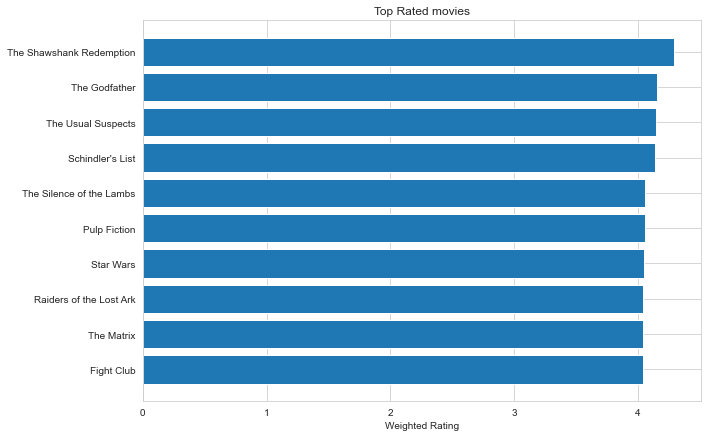

In [18]:
plt.figure(figsize=(10,7))
plt.barh(df3.title.head(10)[::-1],df3.wr.head(10)[::-1])
plt.xlabel('Weighted Rating')
plt.title('Top Rated movies')

Text(0.5, 1.0, 'Highest Grossing Movies')

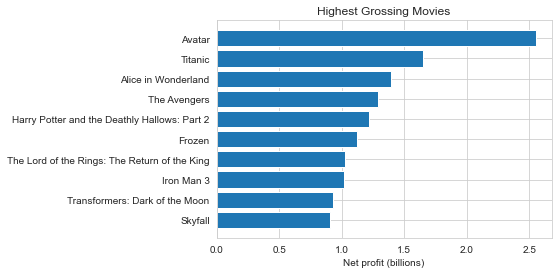

In [19]:
top = df2.groupby('title').sum()['net_profit'].sort_values(ascending = False).head(10)
plt.barh(top.index[::-1], top.values[::-1] / 1000000000)
plt.xlabel('Net profit (billions)')
plt.title('Highest Grossing Movies')

Text(0.5, 1.0, 'Top Rated directors')

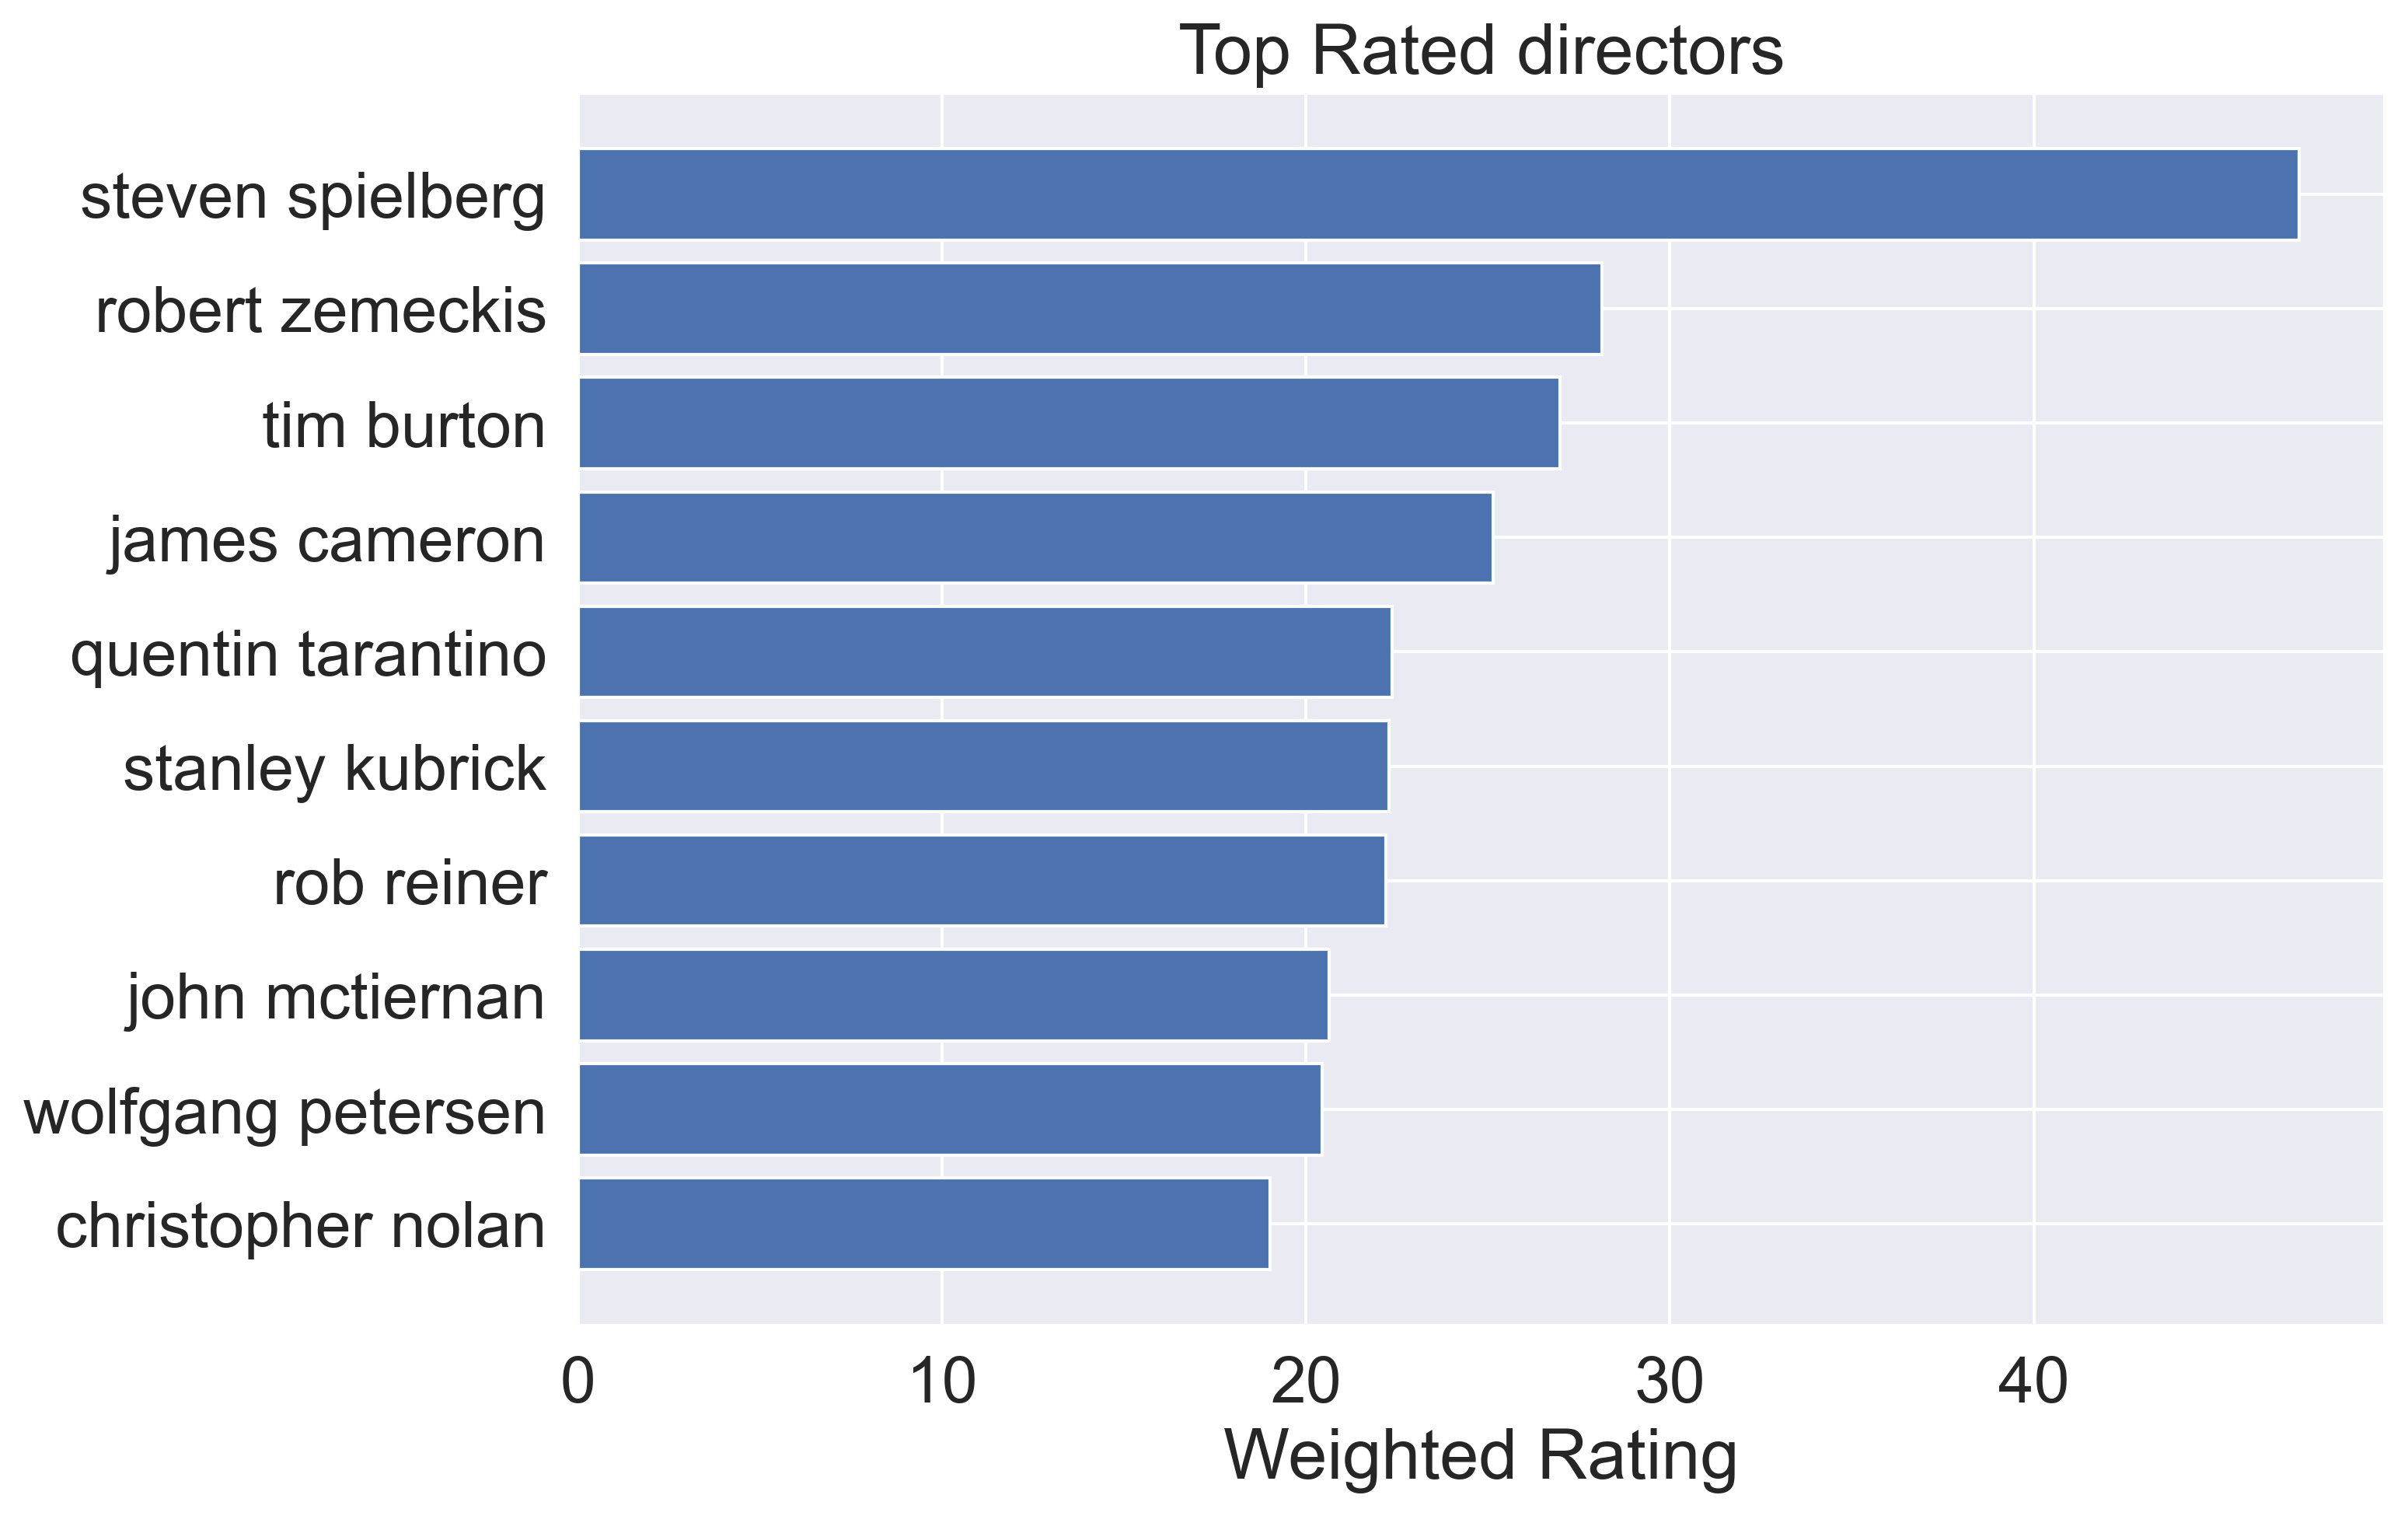

In [136]:
s = df3.apply(lambda x: pd.Series(x['director']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'director'
df4 = df3.drop('director', axis=1).join(s)
plt.figure(figsize=(10,7))
direct = df4.groupby('director', as_index = False).sum().sort_values('wr',ascending = False)
plt.barh(direct.director.head(10)[::-1],direct.wr.head(10)[::-1])
plt.xlabel('Weighted Rating')
plt.title('Top Rated directors')

Text(0.5, 1.0, 'Highest Grossing Directors')

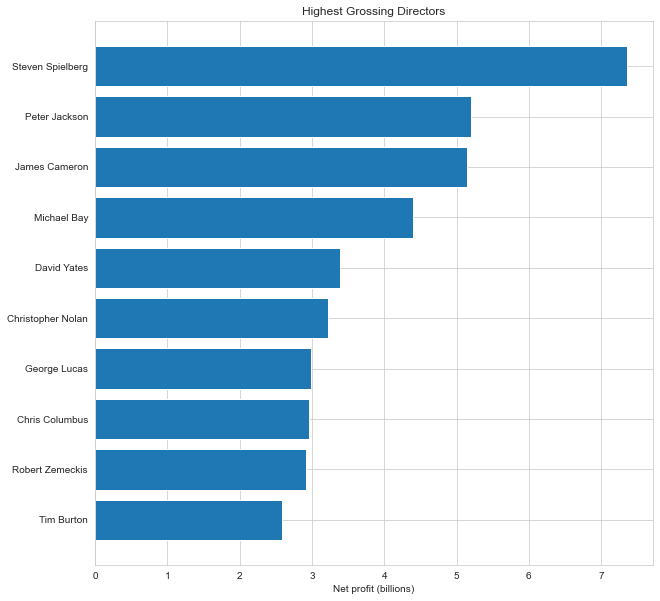

In [21]:
top = df2.groupby('director').sum()['net_profit'].sort_values(ascending = False).head(10)
plt.figure(figsize=(10,10))
plt.barh(top.index[::-1], top.values[::-1] / 1000000000)
plt.xlabel('Net profit (billions)')
plt.title('Highest Grossing Directors')

Text(0.5, 1.0, 'Top Rated Companies')

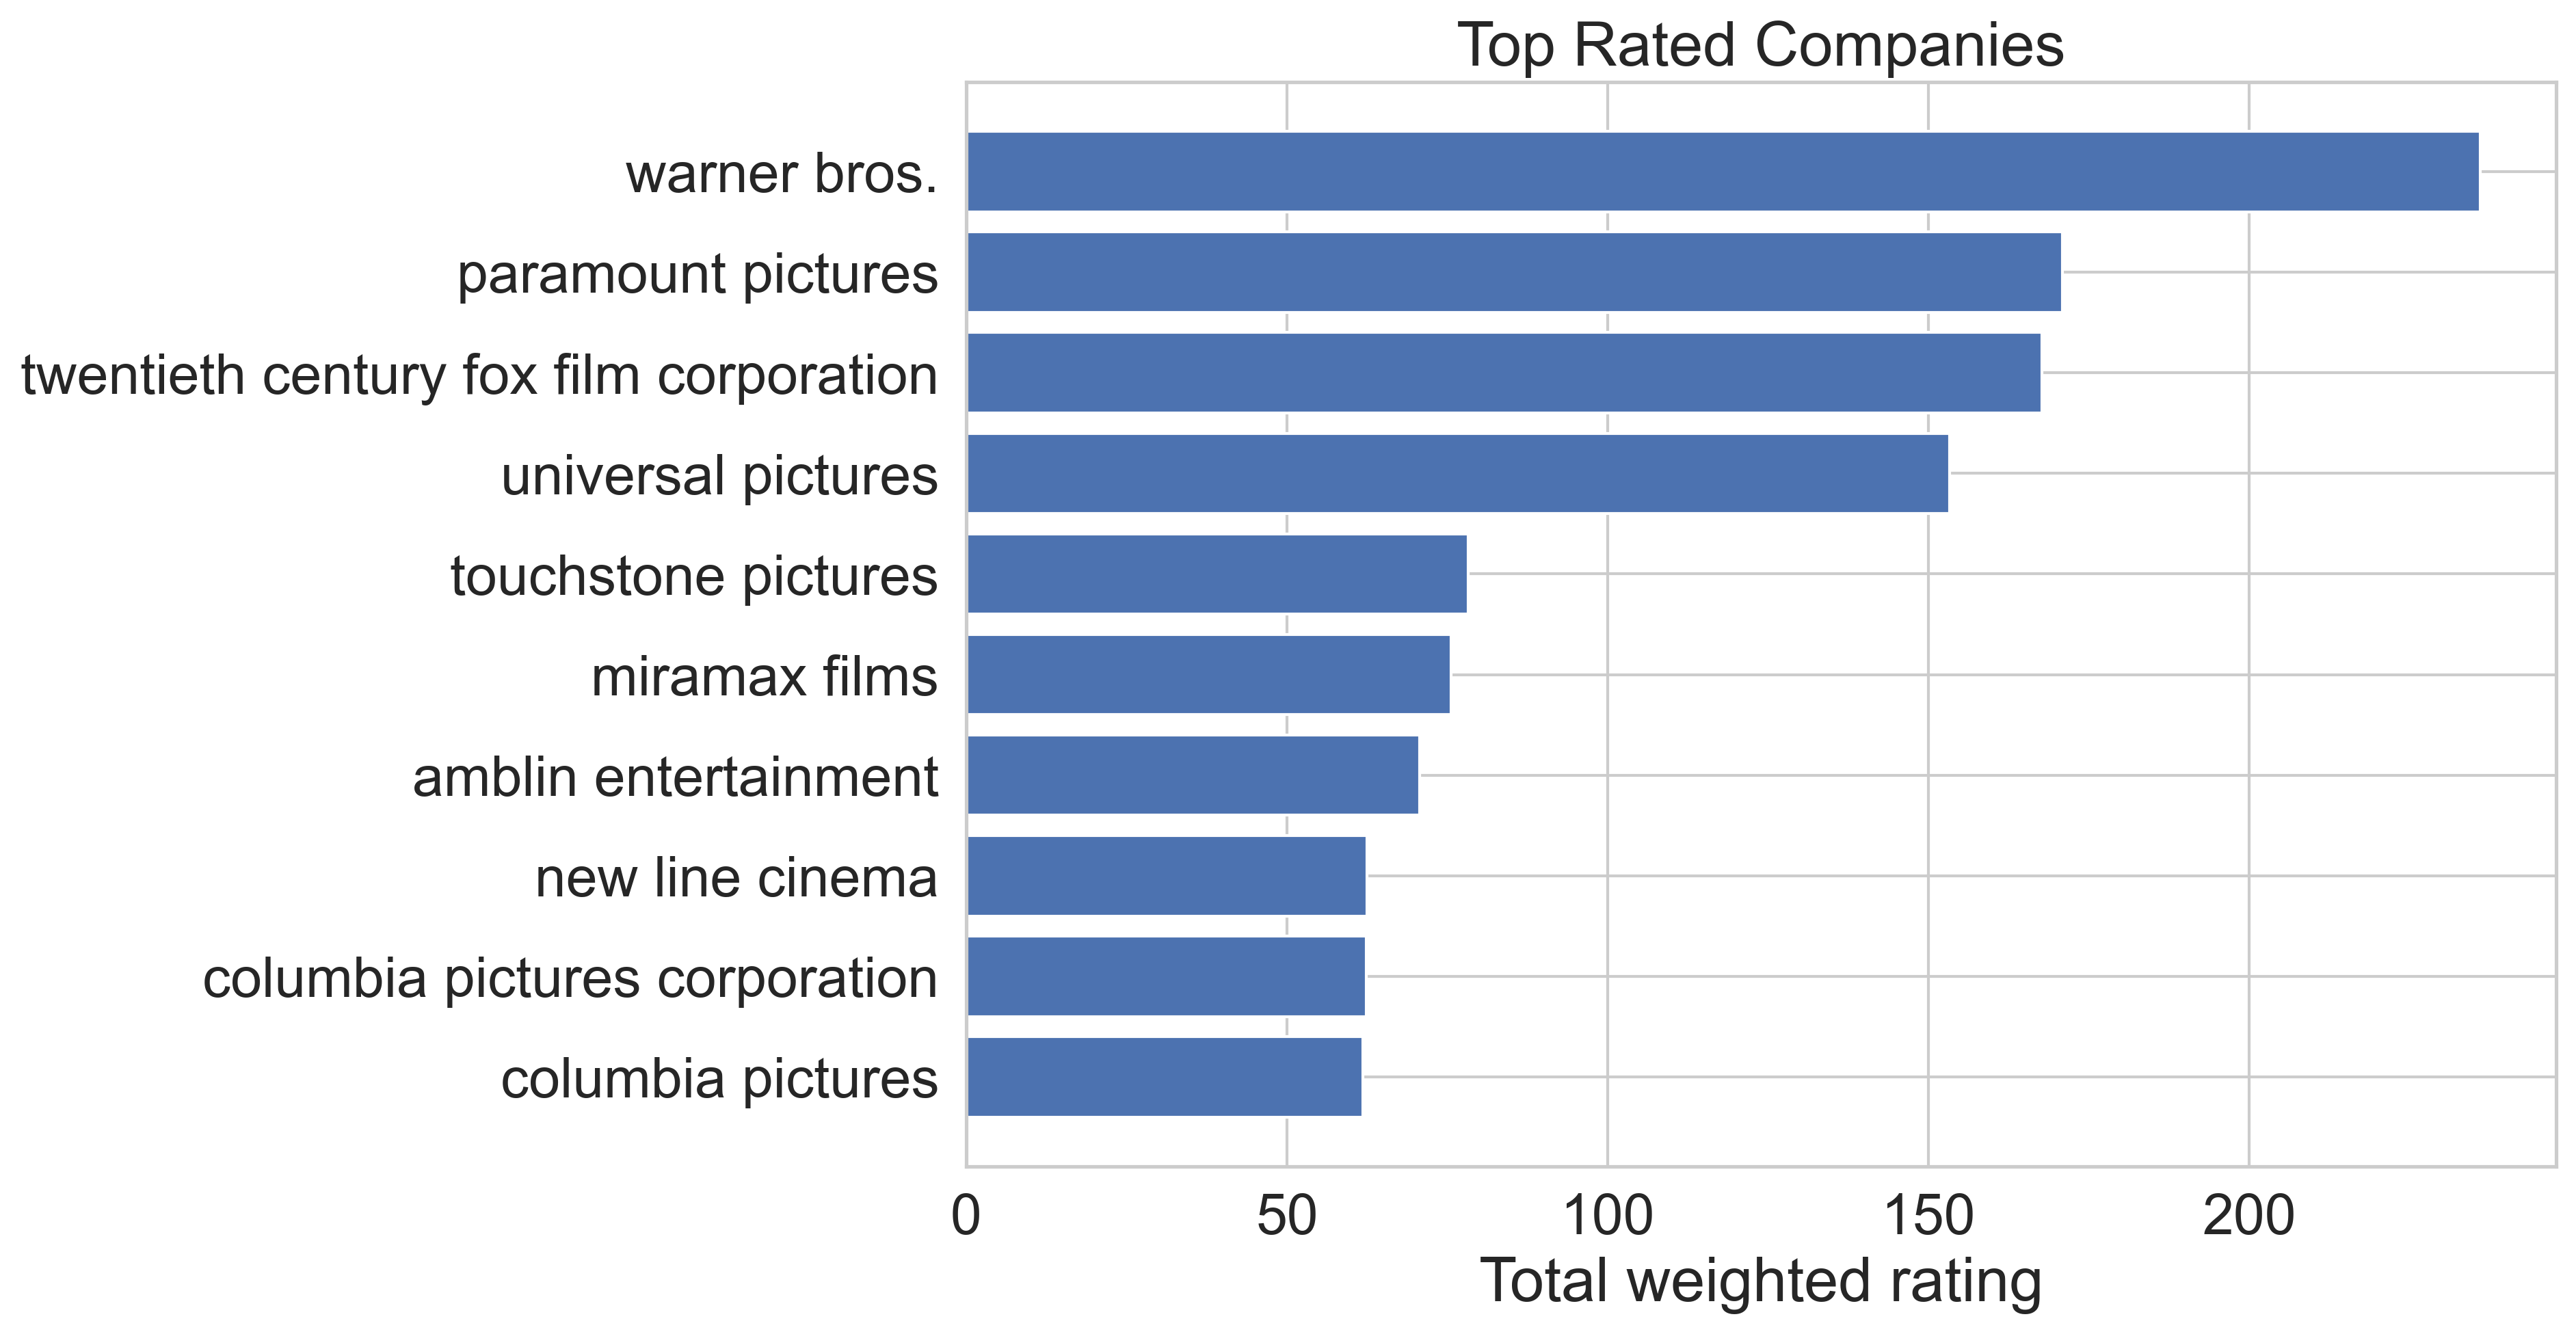

In [100]:
s = df3.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'production_company'
df4 = df3.drop('production_companies', axis=1).join(s)
plt.figure(figsize=(10,7
))
prod = df4.groupby('production_company', as_index = False).sum().sort_values('wr',ascending = False)
plt.barh(prod.production_company.head(10)[::-1],prod.wr.head(10)[::-1])
plt.xlabel('Total weighted rating')
plt.title('Top Rated Companies')

Text(0.5, 1.0, 'Highest Grossing Production Companies')

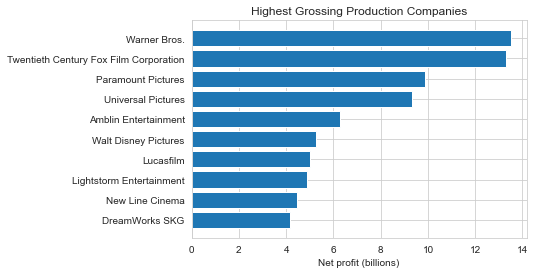

In [23]:
top = df4.groupby('production_company').sum()['net_profit'].sort_values(ascending = False).head(10)
plt.barh(top.index[::-1], top.values[::-1] / 1000000000)
plt.xlabel('Net profit (billions)')
plt.title('Highest Grossing Production Companies')

Text(0.5, 1.0, 'Rating Count per Genre')

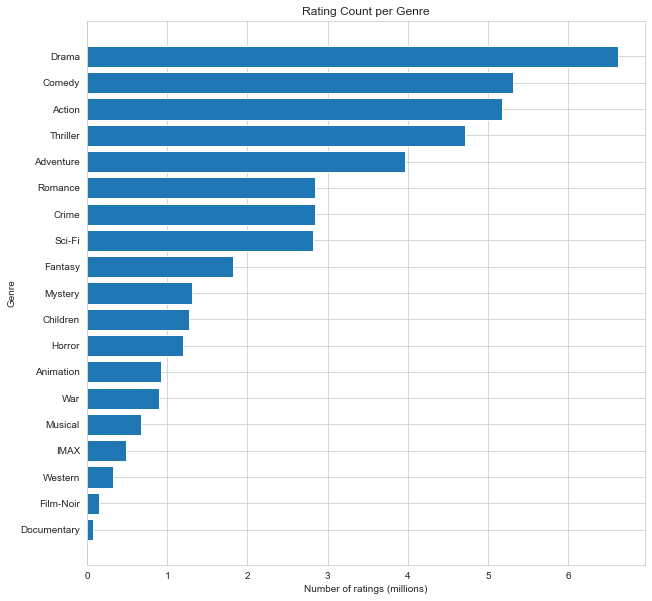

In [24]:

plt.figure(figsize=(10,10))
s = df2.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
df4 = df2.drop('genres', axis=1).join(s)
genre = df4.groupby('genre').sum()['rating_count'].sort_values()
plt.barh(genre.index, genre.values / 1000000)
plt.ylabel('Genre')
plt.xlabel('Number of ratings (millions)')
plt.title('Rating Count per Genre')

Text(0.5, 1.0, 'Highest Grossing Genres')

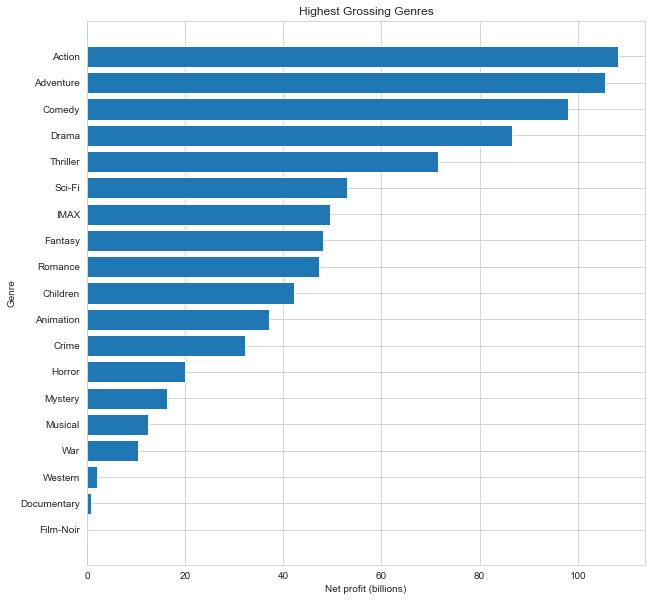

In [25]:
plt.figure(figsize=(10,10))
genre2 = df4.groupby('genre').sum()['net_profit'].sort_values()
plt.barh(genre2.index, genre2.values / 1000000000)
plt.ylabel('Genre')
plt.xlabel('Net profit (billions)')
plt.title('Highest Grossing Genres')

(-50000000.0, 1750000000.0)

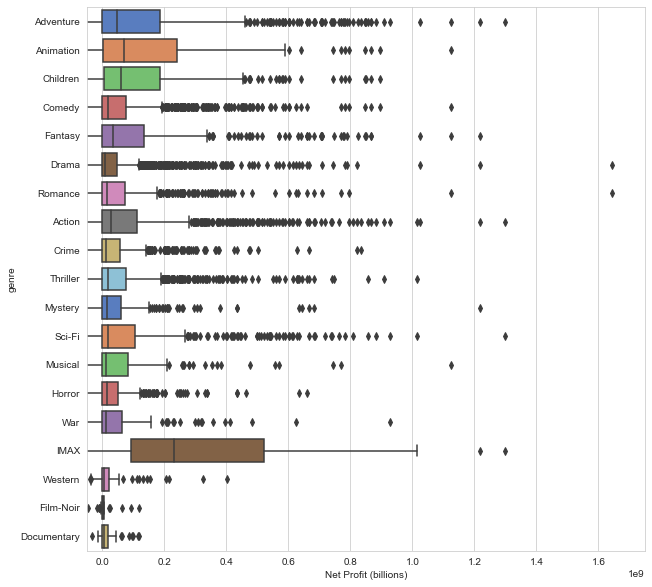

In [26]:
plt.figure(figsize=(10,10))
ax= sns.boxplot(x = df4.net_profit, y= df4.genre , palette = 'muted',orient= 'h')
ax.set_xlabel('Net Profit (billions)')
ax.set_xlim([-50000000, 1.75e9])

# IMAX has the largest median and 25-75 range in net profit, with Animation coming 2nd.

Text(0.5, 1.0, 'Genre average rating')

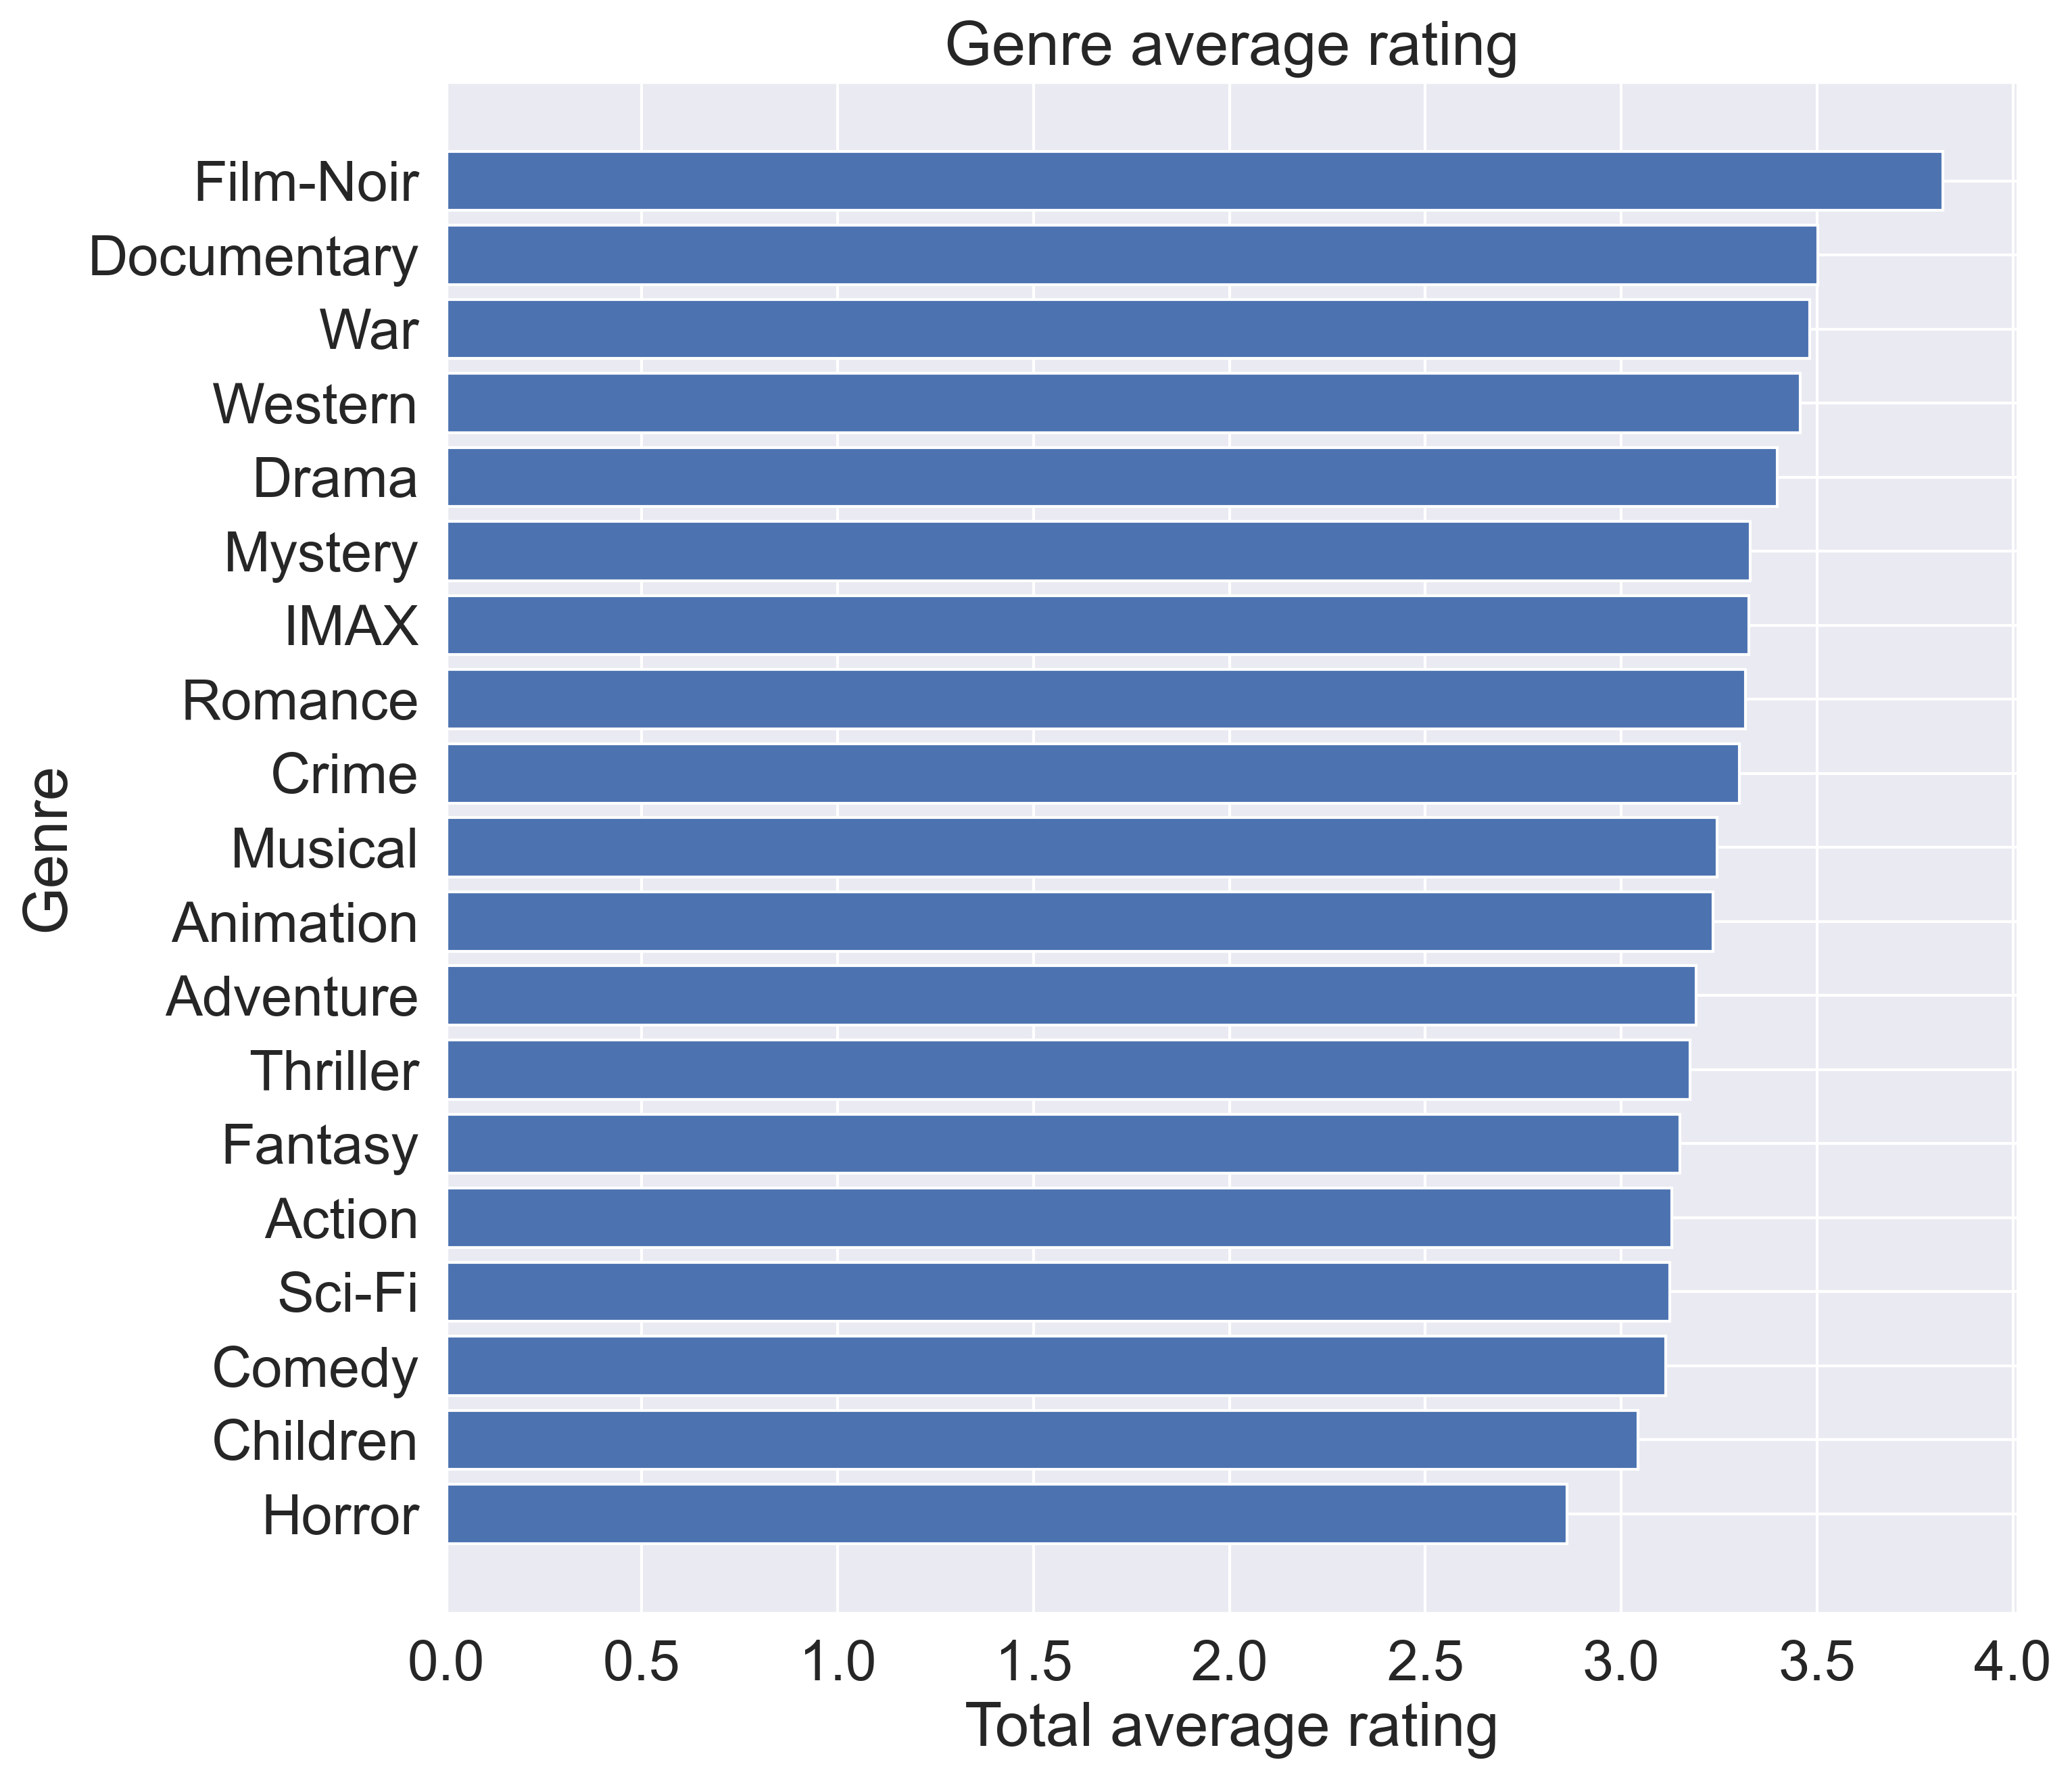

In [76]:
plt.figure(figsize=(10,10))
genre = df4.groupby('genre').mean()['rating_average'].sort_values()
plt.barh(genre.index, genre.values)
plt.ylabel('Genre')
plt.xlabel('Total average rating')
plt.title('Genre average rating')

Text(0.5, 0, 'Average rating')

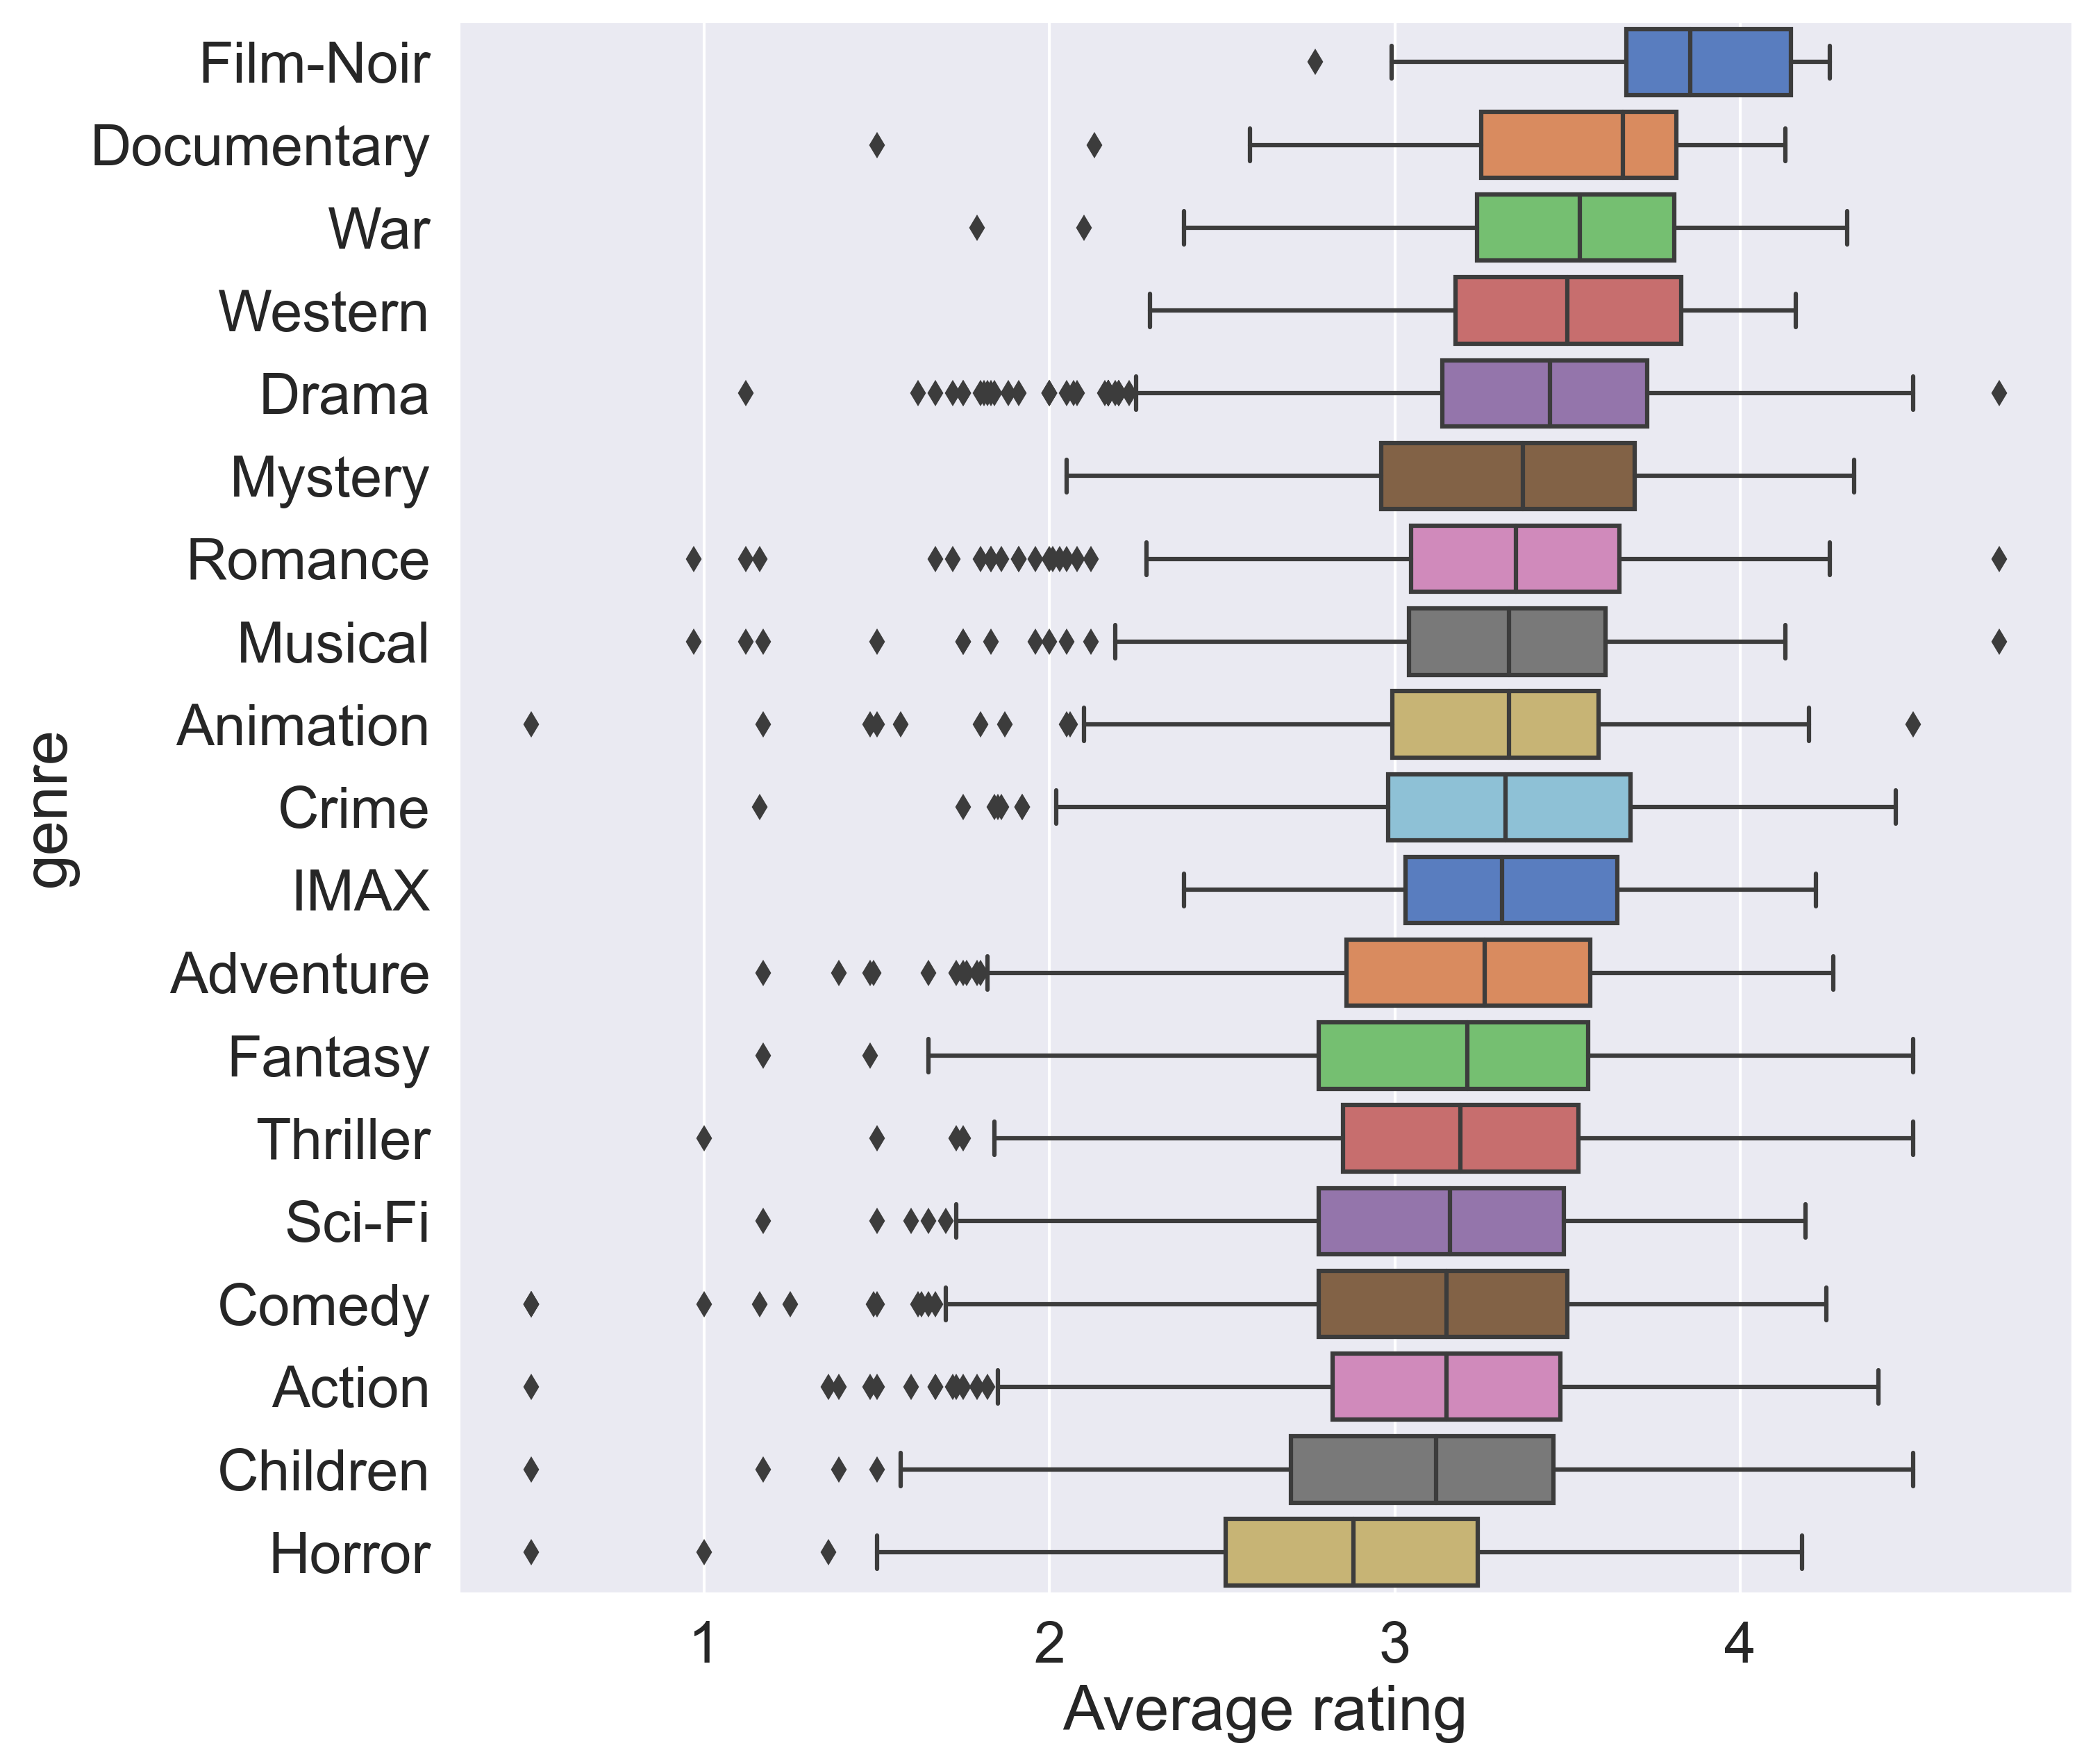

In [96]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize=(10,10))
my_order = df4.groupby("genre")["rating_average"].median().sort_values(ascending = False)
ax= sns.boxplot(x = df4.rating_average, y= df4.genre, palette = 'muted', order = my_order.index,orient= 'h')
ax.set_xlabel('Average rating')

# Film-Noir has the highest median rating. Horror, Fantasy, Comedy, and Children's films compete for the genres with the largest
# IQR.

Text(0.5, 1.0, 'Movies Released per Year')

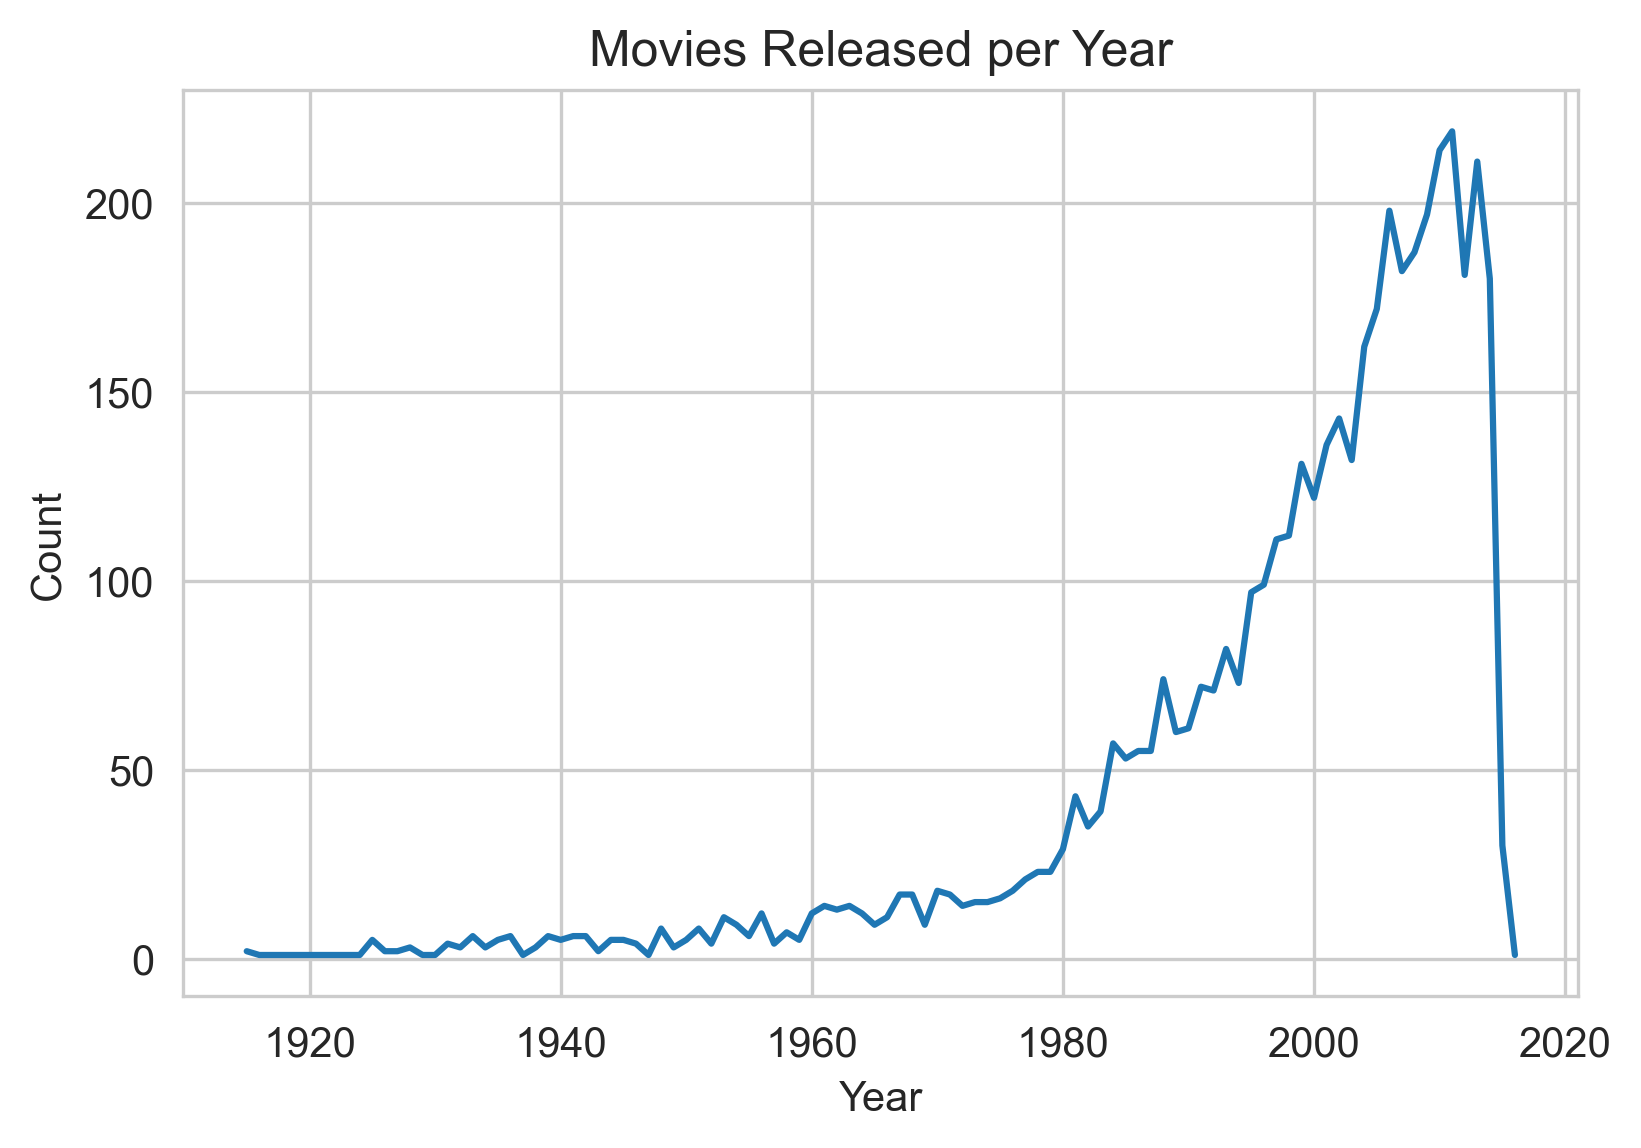

In [29]:
year = df2.groupby('release_year').count()['movieId'].head(97)
plt.plot(year.index, year.values)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Movies Released per Year')

Text(0.5, 1.0, 'Sum of Rating counts per Year')

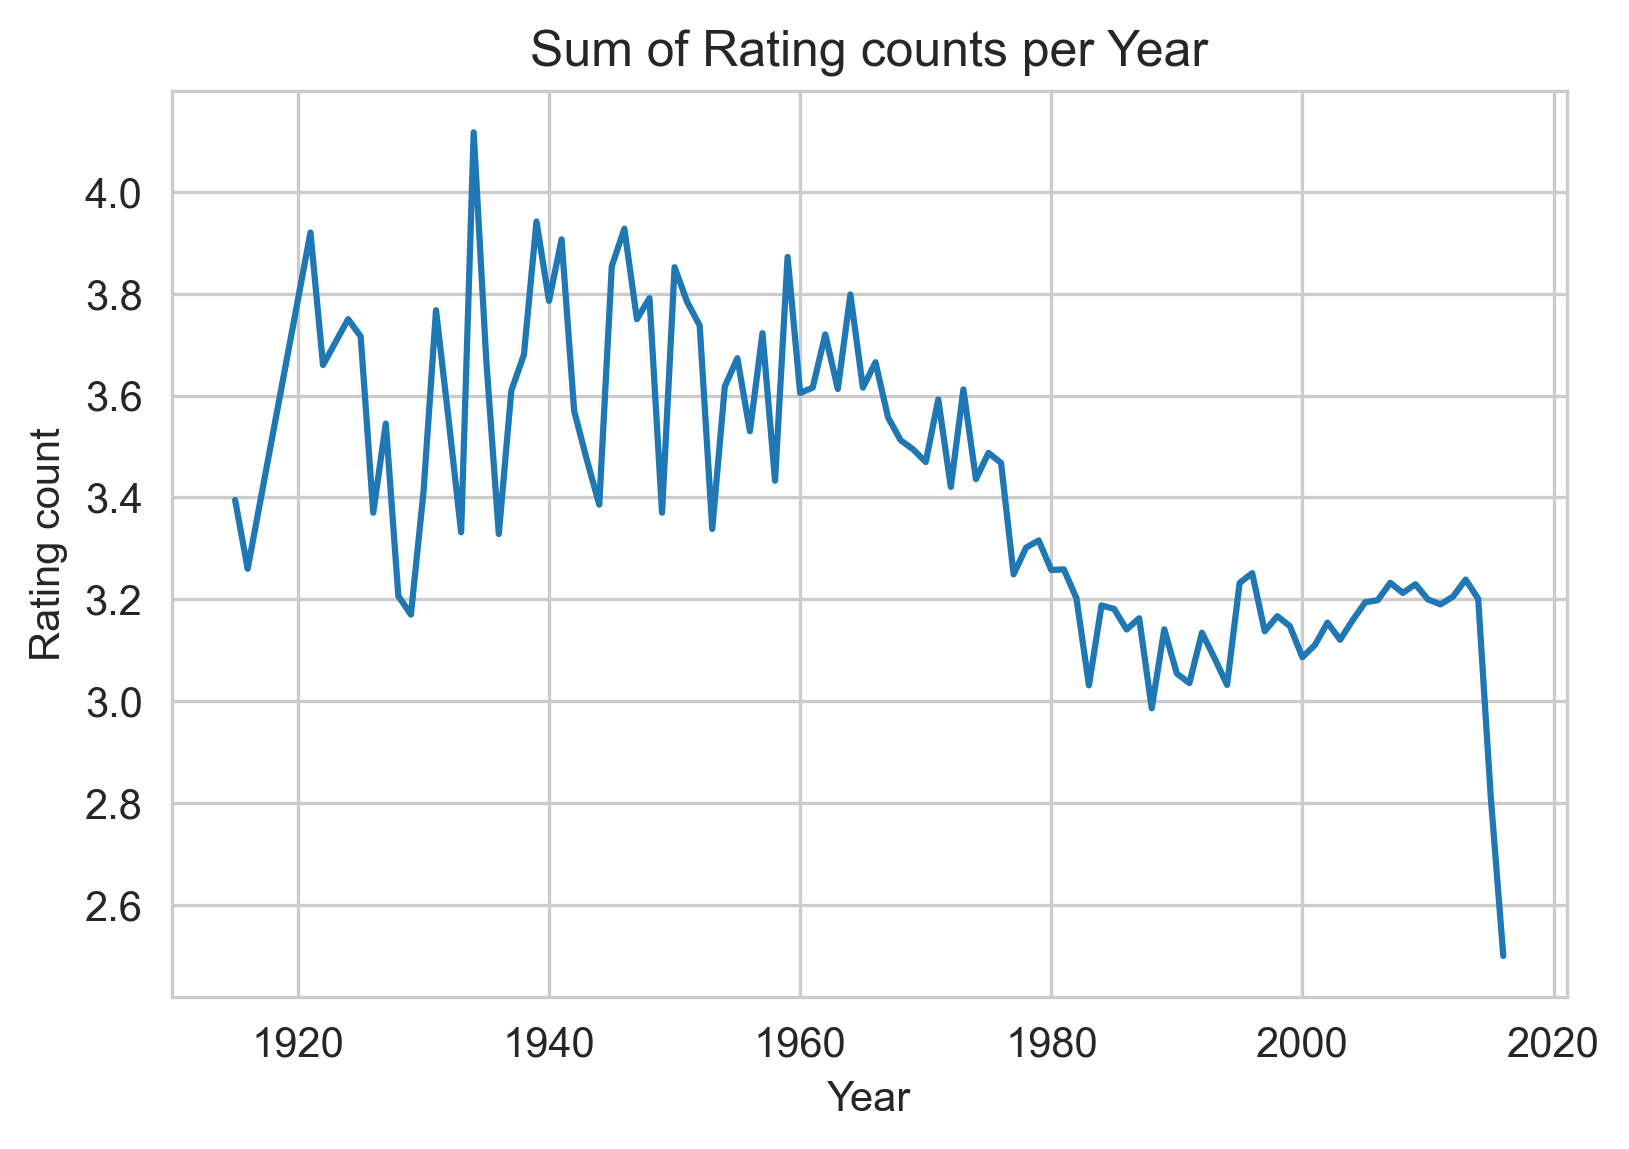

In [30]:
year = df2.groupby('release_year').mean()['rating_average']
plt.plot(year.index, year.values)
plt.ylabel('Rating count')
plt.xlabel('Year')
plt.title('Sum of Rating counts per Year')

Text(0.5, 1.0, 'Average Rating per Year')

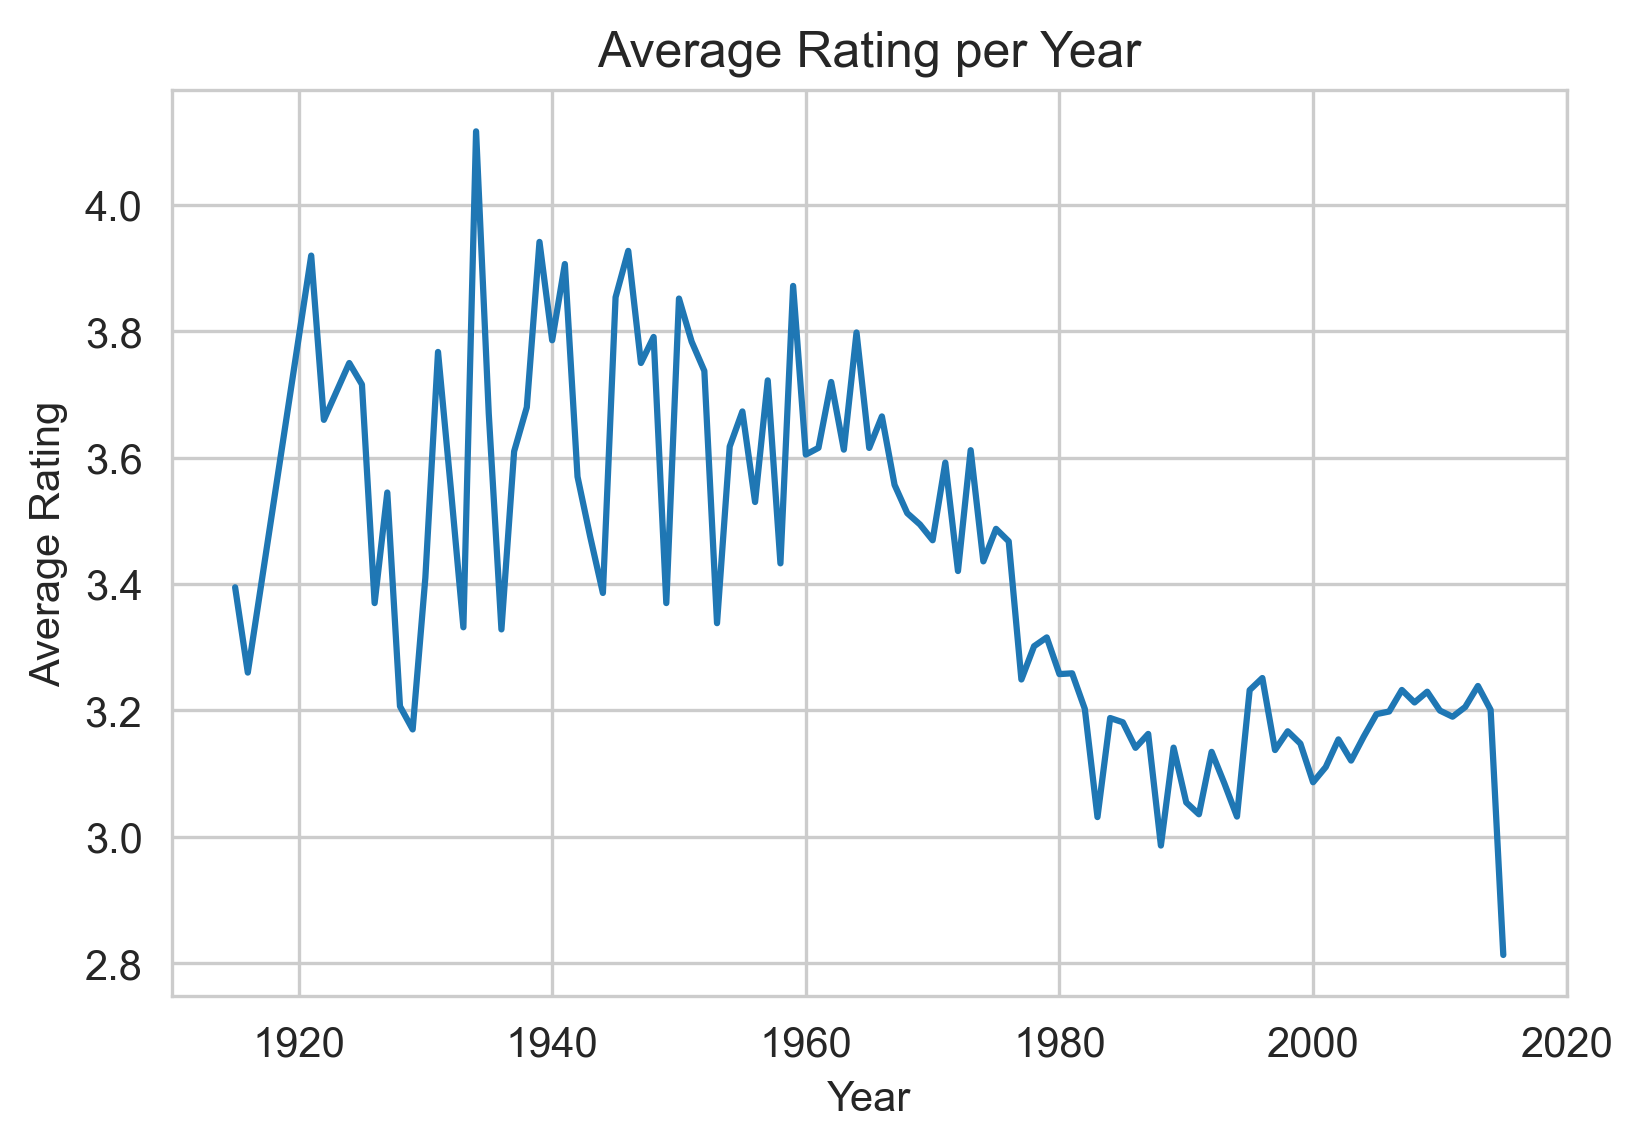

In [31]:
year = df2.groupby('release_year').mean().head(96)['rating_average']
plt.plot(year.index, year.values)
plt.ylabel('Average Rating')
plt.xlabel('Year')
plt.title('Average Rating per Year')

Text(0.5, 1.0, 'Average Net Profit per Year')

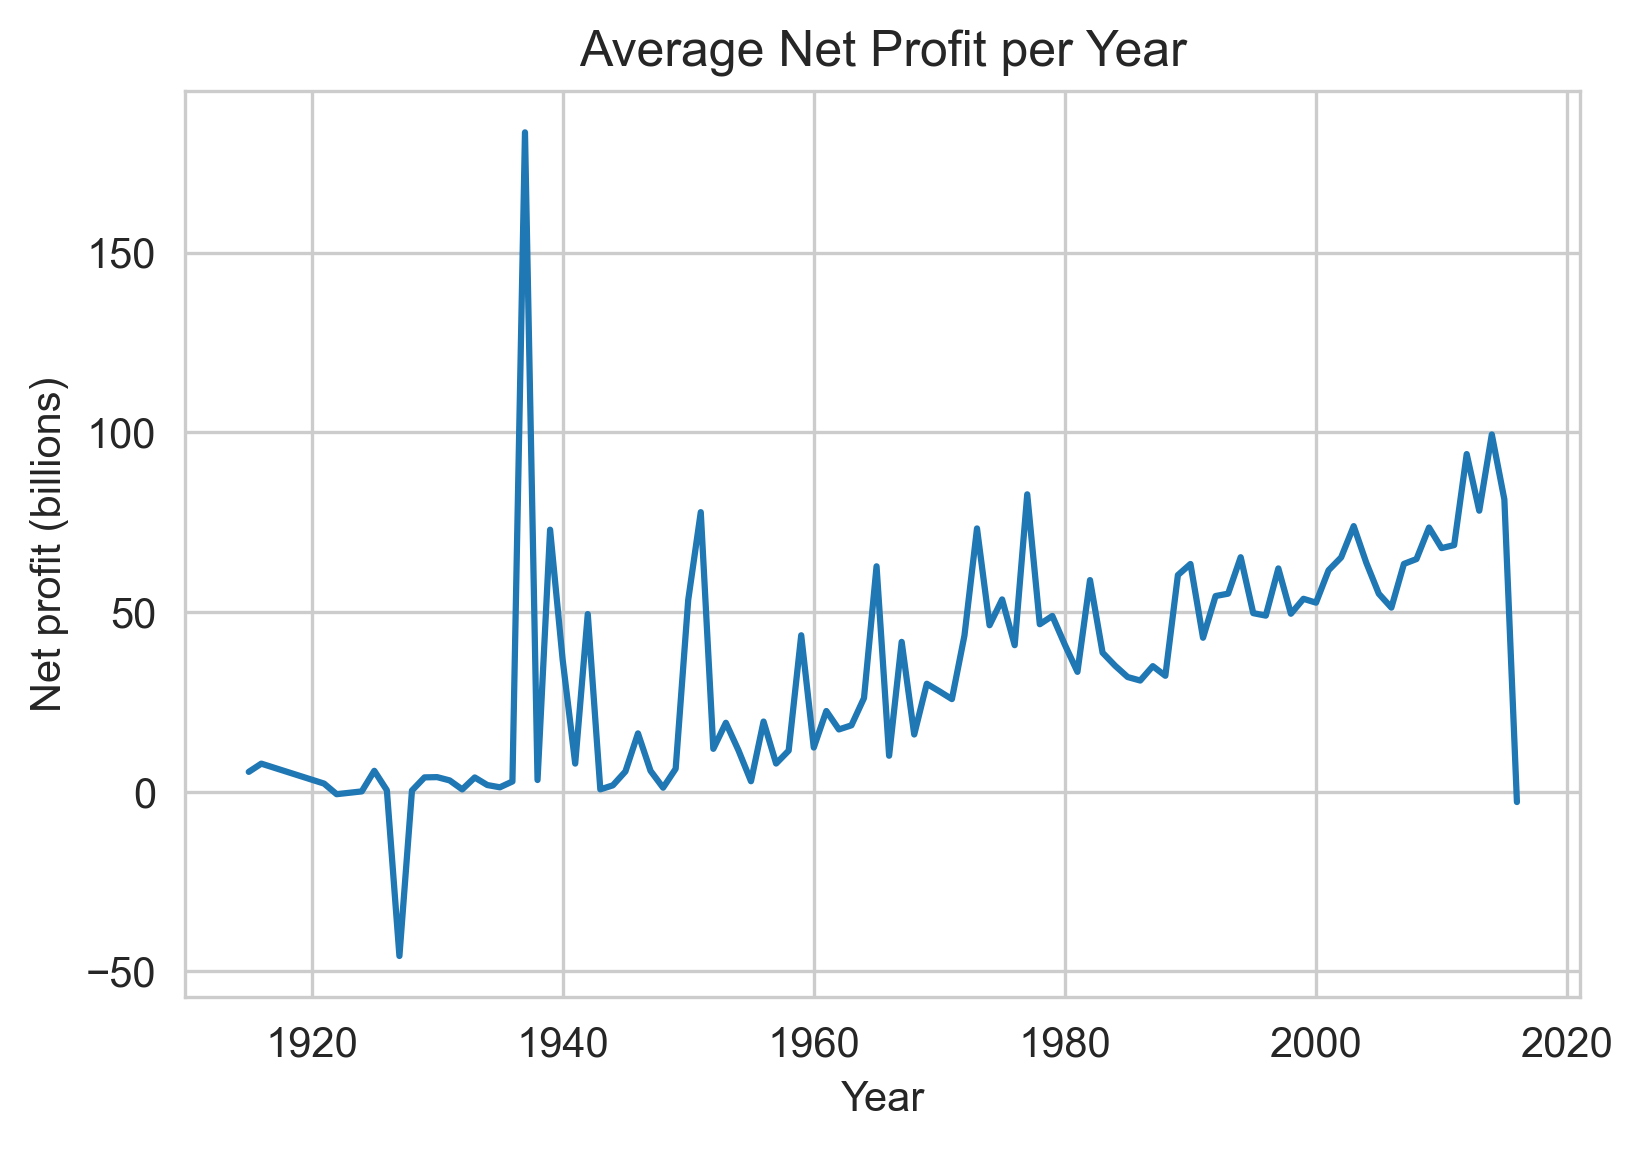

In [33]:
year = df2.groupby('release_year').mean()['net_profit'] / 1000000
plt.plot(year.index, year.values)
plt.ylabel('Net profit (billions)')
plt.xlabel('Year')
plt.title('Average Net Profit per Year')

Text(0.5, 1.0, 'Max Profit per Year')

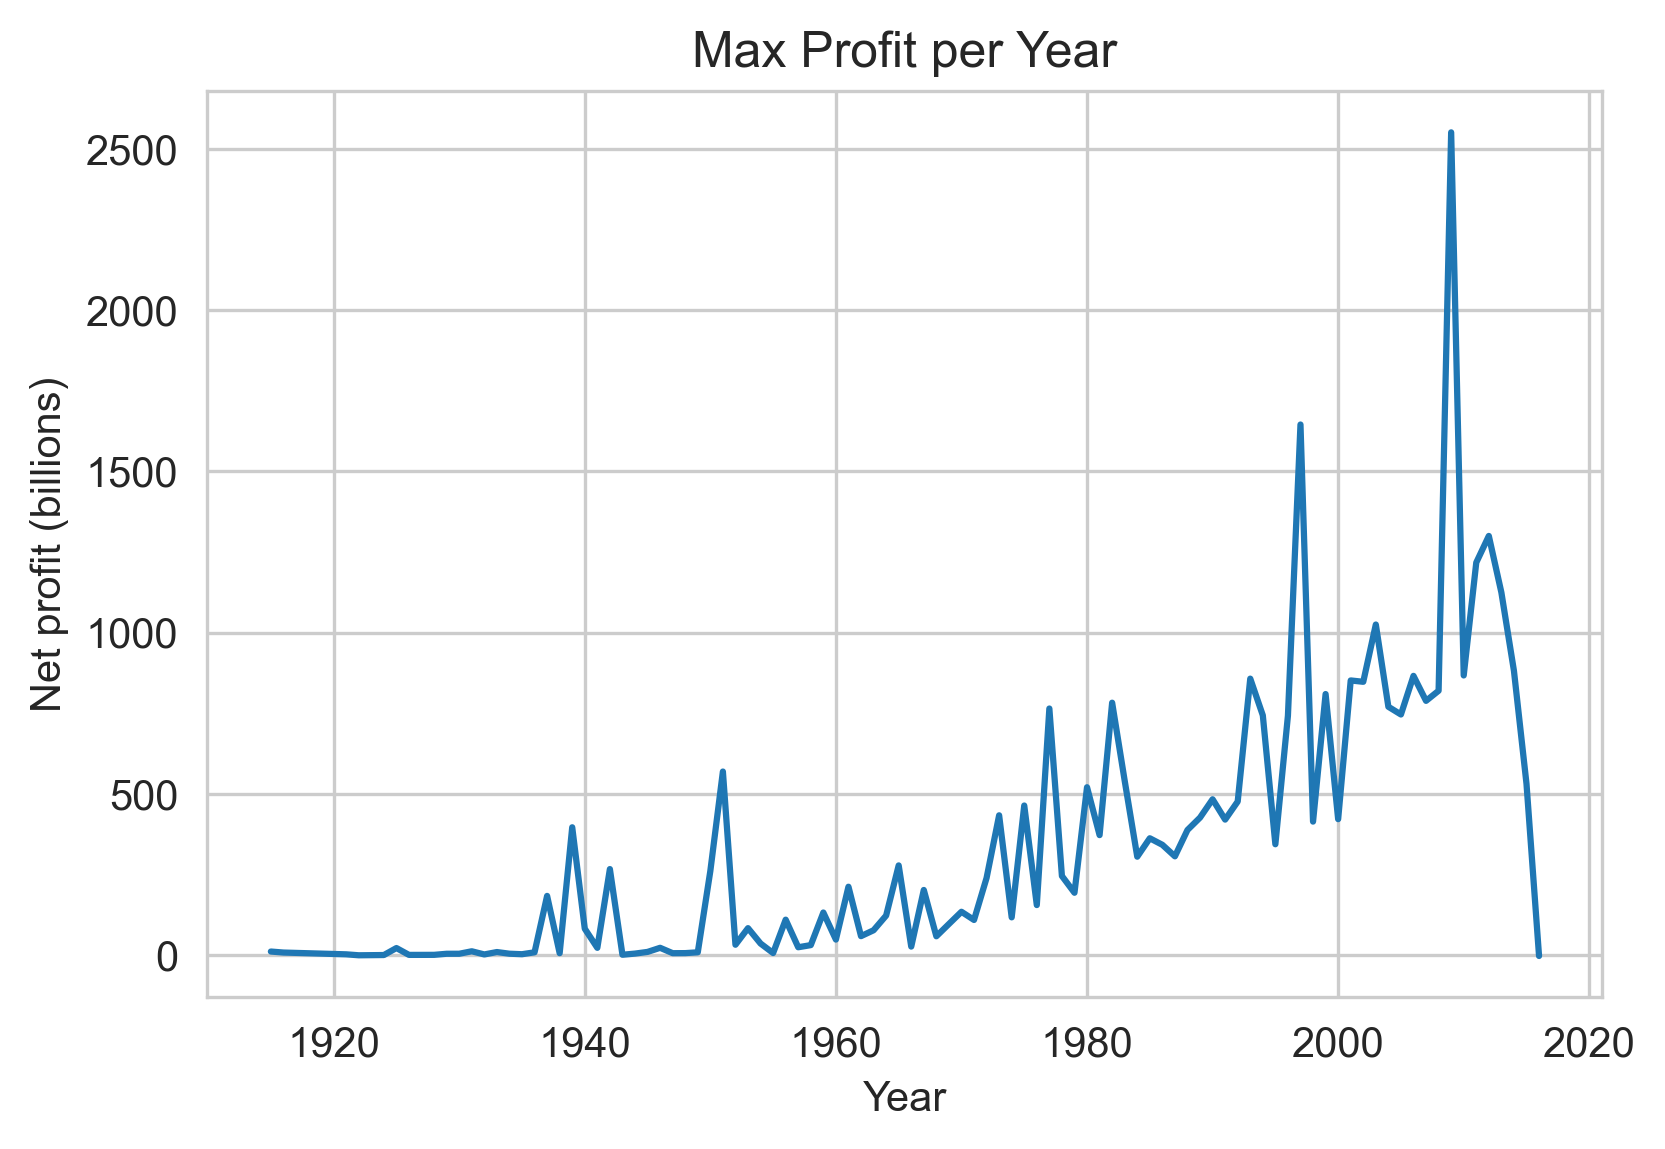

In [34]:
year = df2.groupby('release_year').max()['net_profit'] / 1000000
plt.plot(year.index, year.values)
plt.ylabel('Net profit (billions)')
plt.xlabel('Year')
plt.title('Max Profit per Year')

Text(0.5, 1.0, 'Average Movie Duration per year')

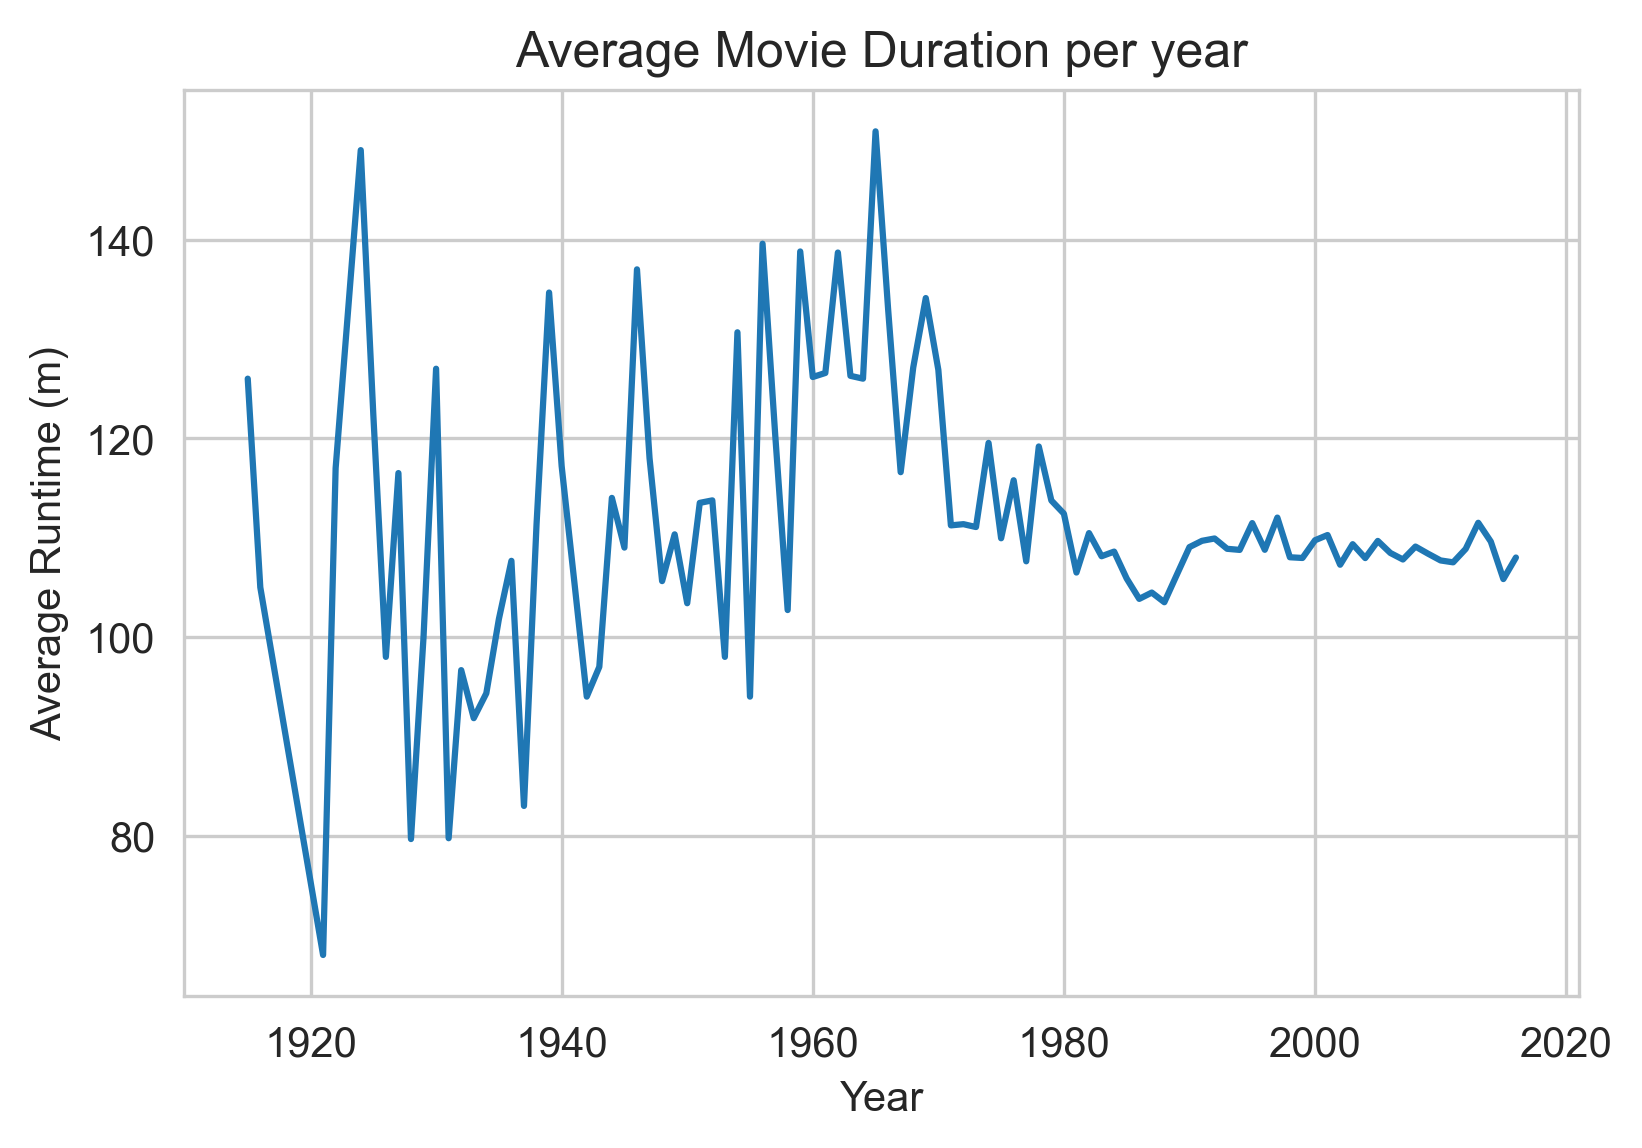

In [35]:
year = df2.groupby('release_year').mean()['runtime']
plt.plot(year.index, year.values)
plt.ylabel('Average Runtime (m)')
plt.xlabel('Year')
plt.title('Average Movie Duration per year')

Text(0.5, 1.0, 'Crew Size Distribution')

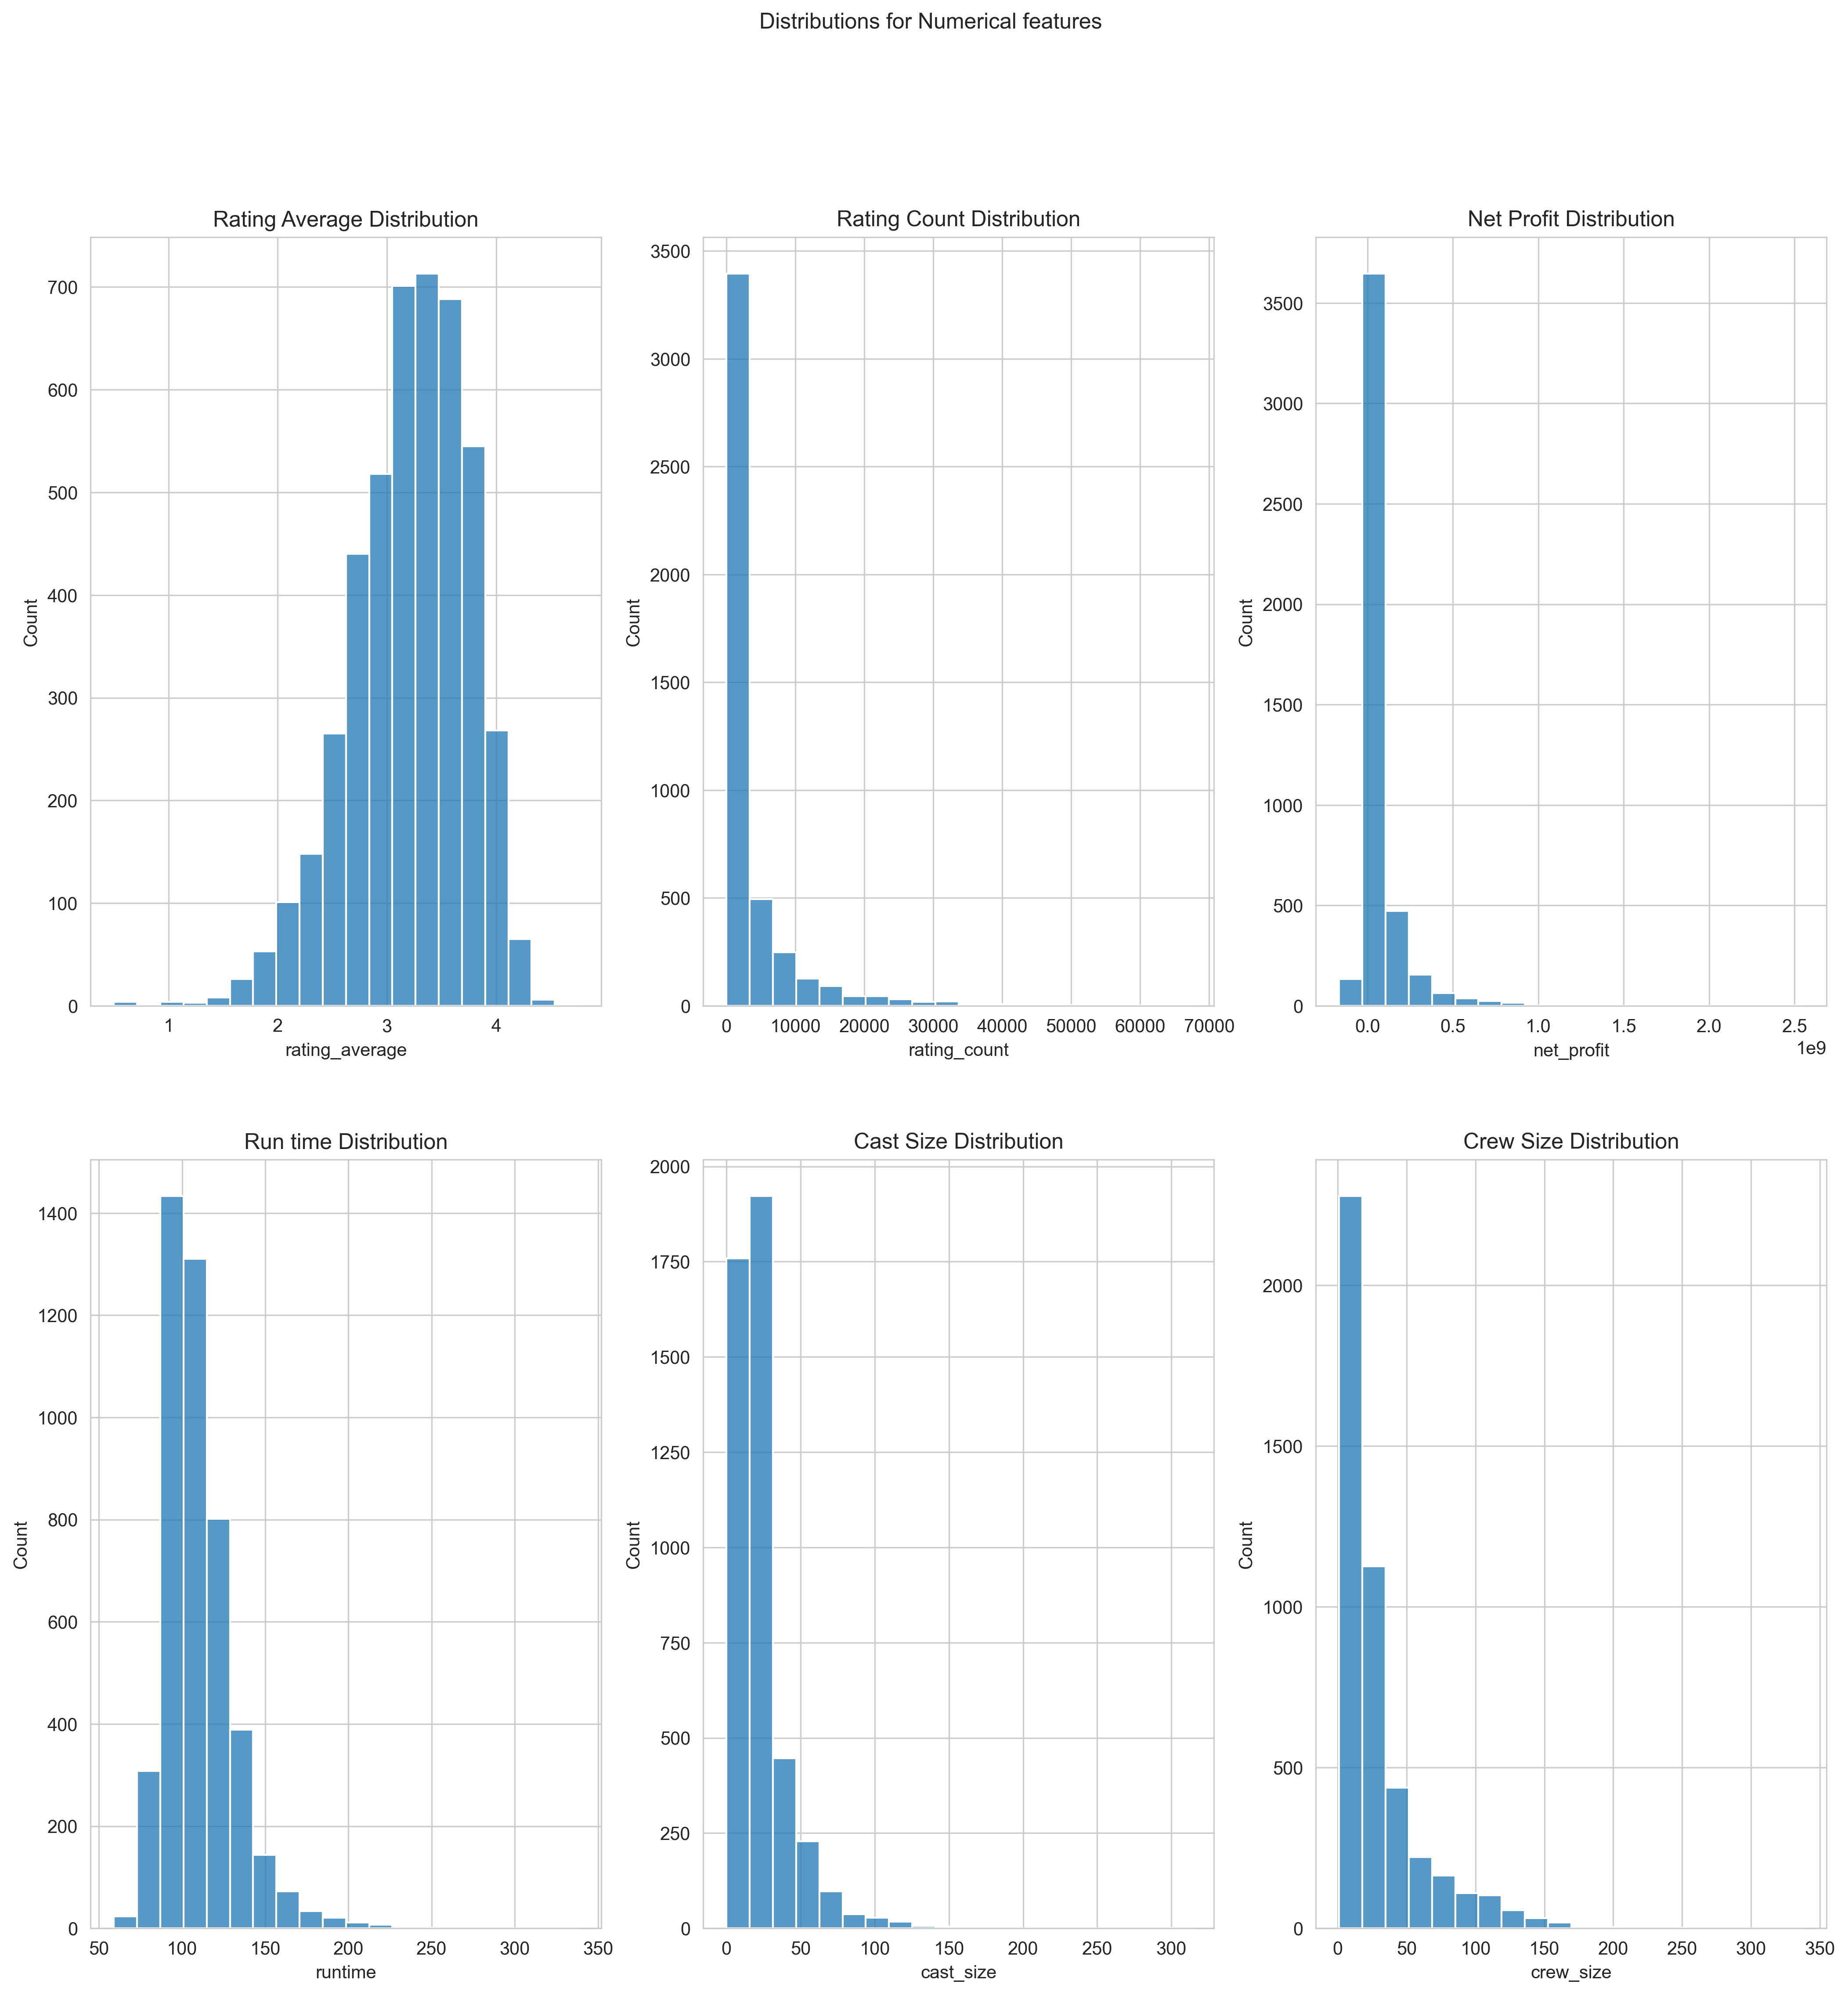

In [36]:
fig, ax = plt.subplots(2,3, figsize = (17,17))
fig.suptitle('Distributions for Numerical features')
sns.histplot(df2.rating_average, bins = 20, ax = ax[0,0])
ax[0,0].set_title('Rating Average Distribution')
sns.histplot(df2.rating_count, bins = 20, ax = ax[0,1])
ax[0,1].set_title('Rating Count Distribution')
sns.histplot(df2.net_profit, bins = 20, ax = ax[0,2])
ax[0,2].set_title('Net Profit Distribution')
sns.histplot(df2.runtime, bins = 20, ax = ax[1,0])
ax[1,0].set_title('Run time Distribution')
sns.histplot(df2.cast_size, bins = 20, ax = ax[1,1])
ax[1,1].set_title('Cast Size Distribution')
sns.histplot(df2.crew_size, bins = 20, ax = ax[1,2])
ax[1,2].set_title('Crew Size Distribution')

Text(0.5, 1.0, 'Rating Count Distribution')

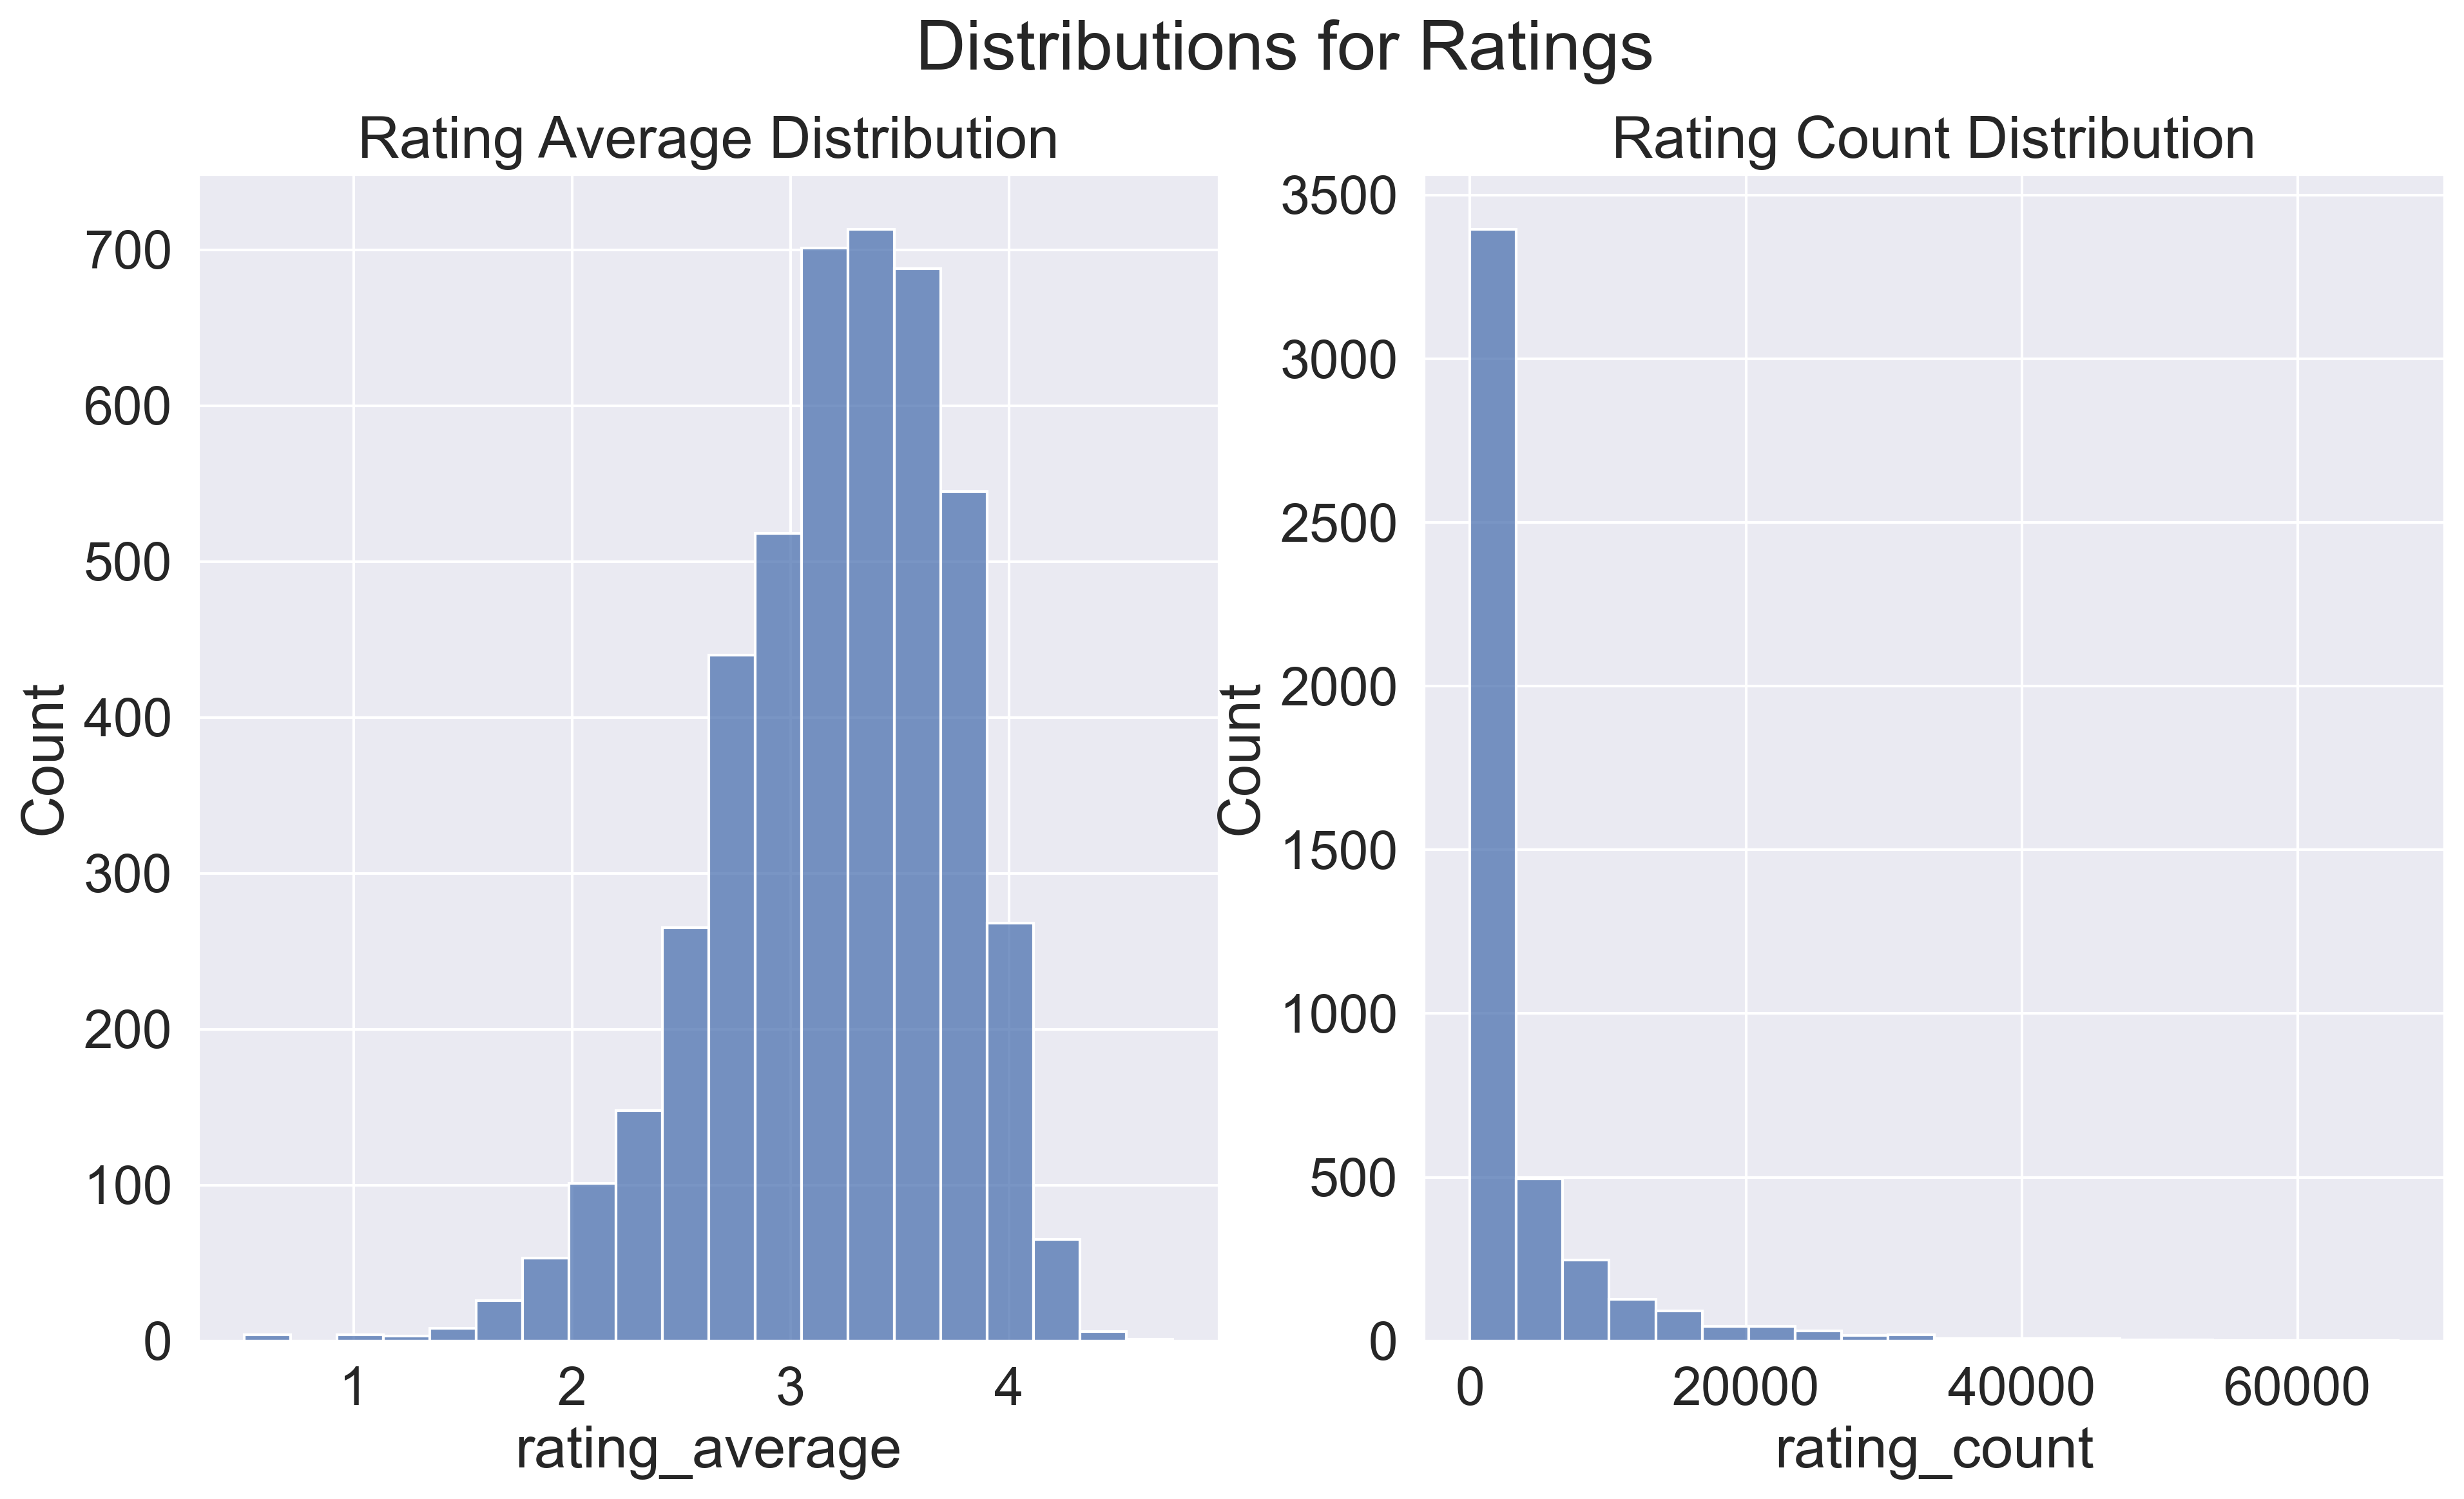

In [127]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,8))
fig.suptitle('Distributions for Ratings')
sns.histplot(df2.rating_average, bins = 20, ax = ax1)
ax1.set_title('Rating Average Distribution')
sns.histplot(df2.rating_count, bins = 20, ax = ax2)
ax2.set_title('Rating Count Distribution')

Text(0.5, 1.0, 'Crew Size Distribution')

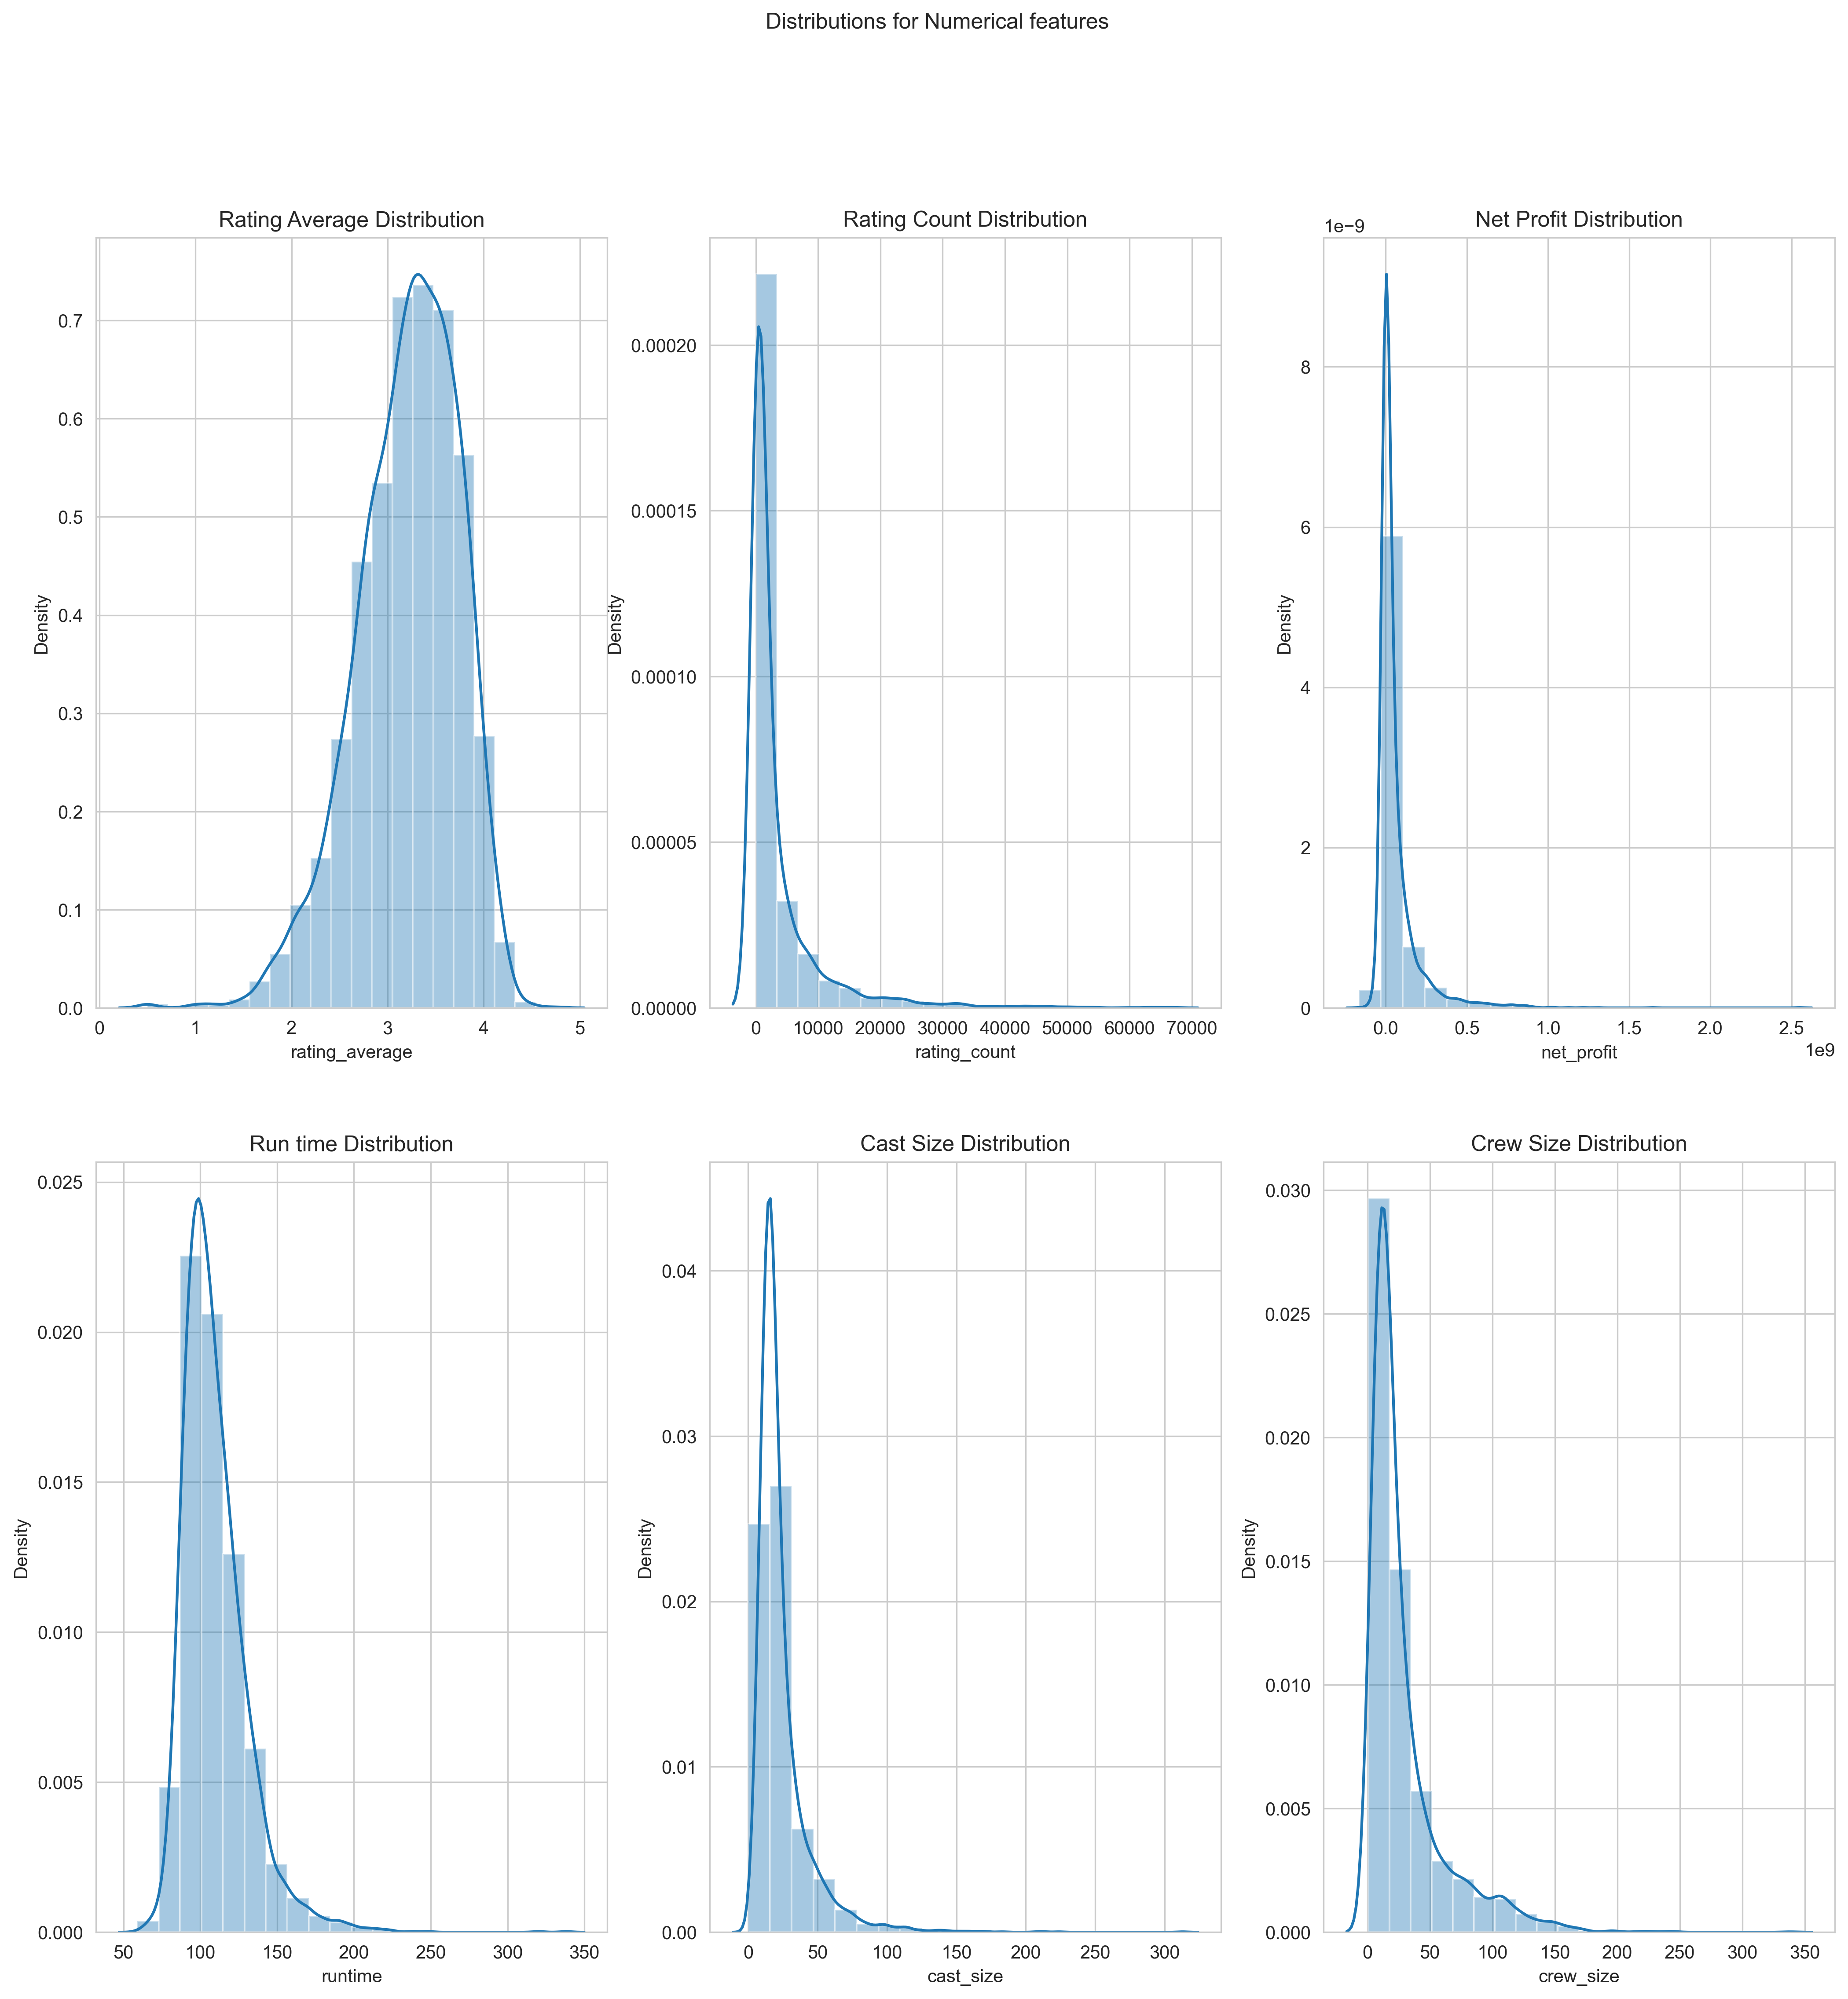

In [42]:
fig, ax = plt.subplots(2,3, figsize = (17,17))
fig.suptitle('Distributions for Numerical features')
sns.distplot(df2.rating_average, bins = 20, ax = ax[0,0])
ax[0,0].set_title('Rating Average Distribution')
sns.distplot(df2.rating_count, bins = 20, ax = ax[0,1])
ax[0,1].set_title('Rating Count Distribution')
sns.distplot(df2.net_profit, bins = 20, ax = ax[0,2])
ax[0,2].set_title('Net Profit Distribution')
sns.distplot(df2.runtime, bins = 20, ax = ax[1,0])
ax[1,0].set_title('Run time Distribution')
sns.distplot(df2.cast_size, bins = 20, ax = ax[1,1])
ax[1,1].set_title('Cast Size Distribution')
sns.distplot(df2.crew_size, bins = 20, ax = ax[1,2])
ax[1,2].set_title('Crew Size Distribution')

Text(0.5, 1.0, 'Popularity vs Rating average')

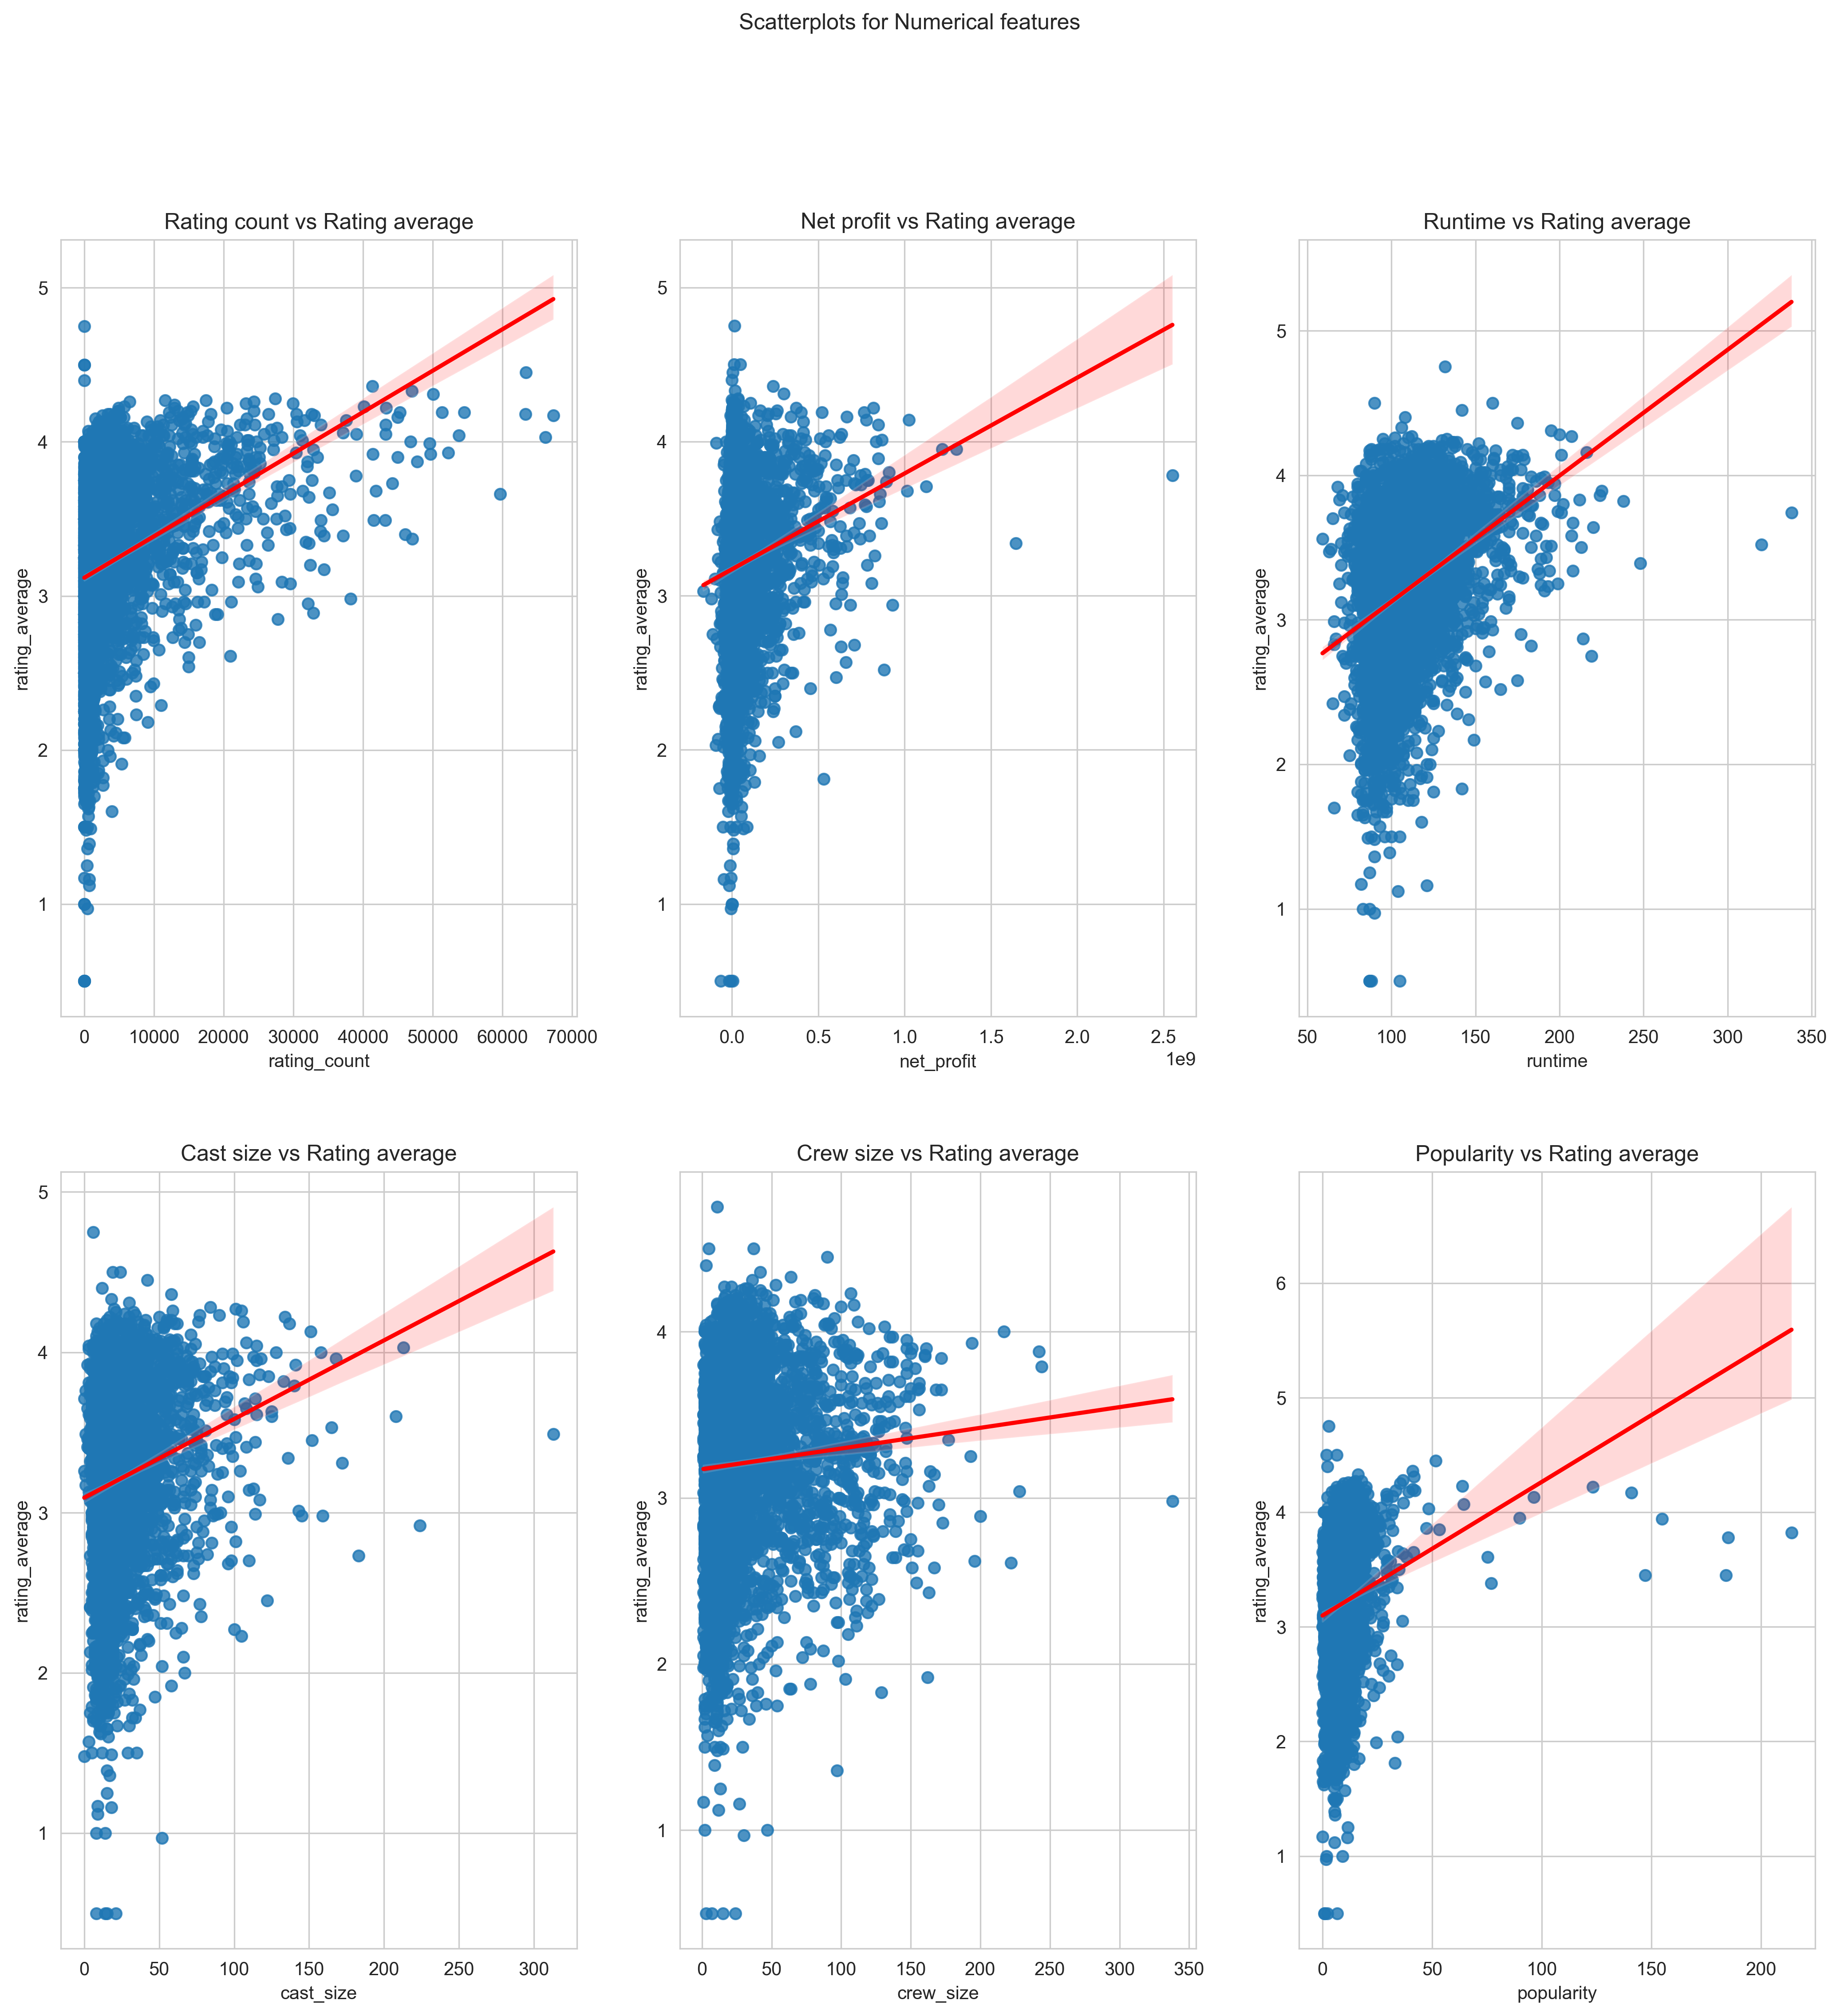

In [43]:
fig, ax = plt.subplots(2,3, figsize = (17,17))
fig.suptitle('Scatterplots for Numerical features')
sns.regplot( x= df2.rating_count, y = df2.rating_average, ax = ax[0,0], line_kws={"color": "red"})
ax[0,0].set_title('Rating count vs Rating average')
sns.regplot( x= df2.net_profit, y = df2.rating_average, ax = ax[0,1], line_kws={"color": "red"})
ax[0,1].set_title('Net profit vs Rating average')
sns.regplot( x= df2.runtime, y = df2.rating_average, ax = ax[0,2], line_kws={"color": "red"})
ax[0,2].set_title('Runtime vs Rating average')
sns.regplot( x= df2.cast_size, y = df2.rating_average, ax = ax[1,0], line_kws={"color": "red"})
ax[1,0].set_title('Cast size vs Rating average')
sns.regplot( x= df2.crew_size, y = df2.rating_average, ax = ax[1,1], line_kws={"color": "red"})
ax[1,1].set_title('Crew size vs Rating average')
sns.regplot( x= df2.popularity, y = df2.rating_average, ax = ax[1,2], line_kws={"color": "red"})
ax[1,2].set_title('Popularity vs Rating average')

# there are some visible correlations with rating - namely, rating count, net profit, runtime, cast size, and popularity.

<AxesSubplot: xlabel='rating_count', ylabel='rating_average'>

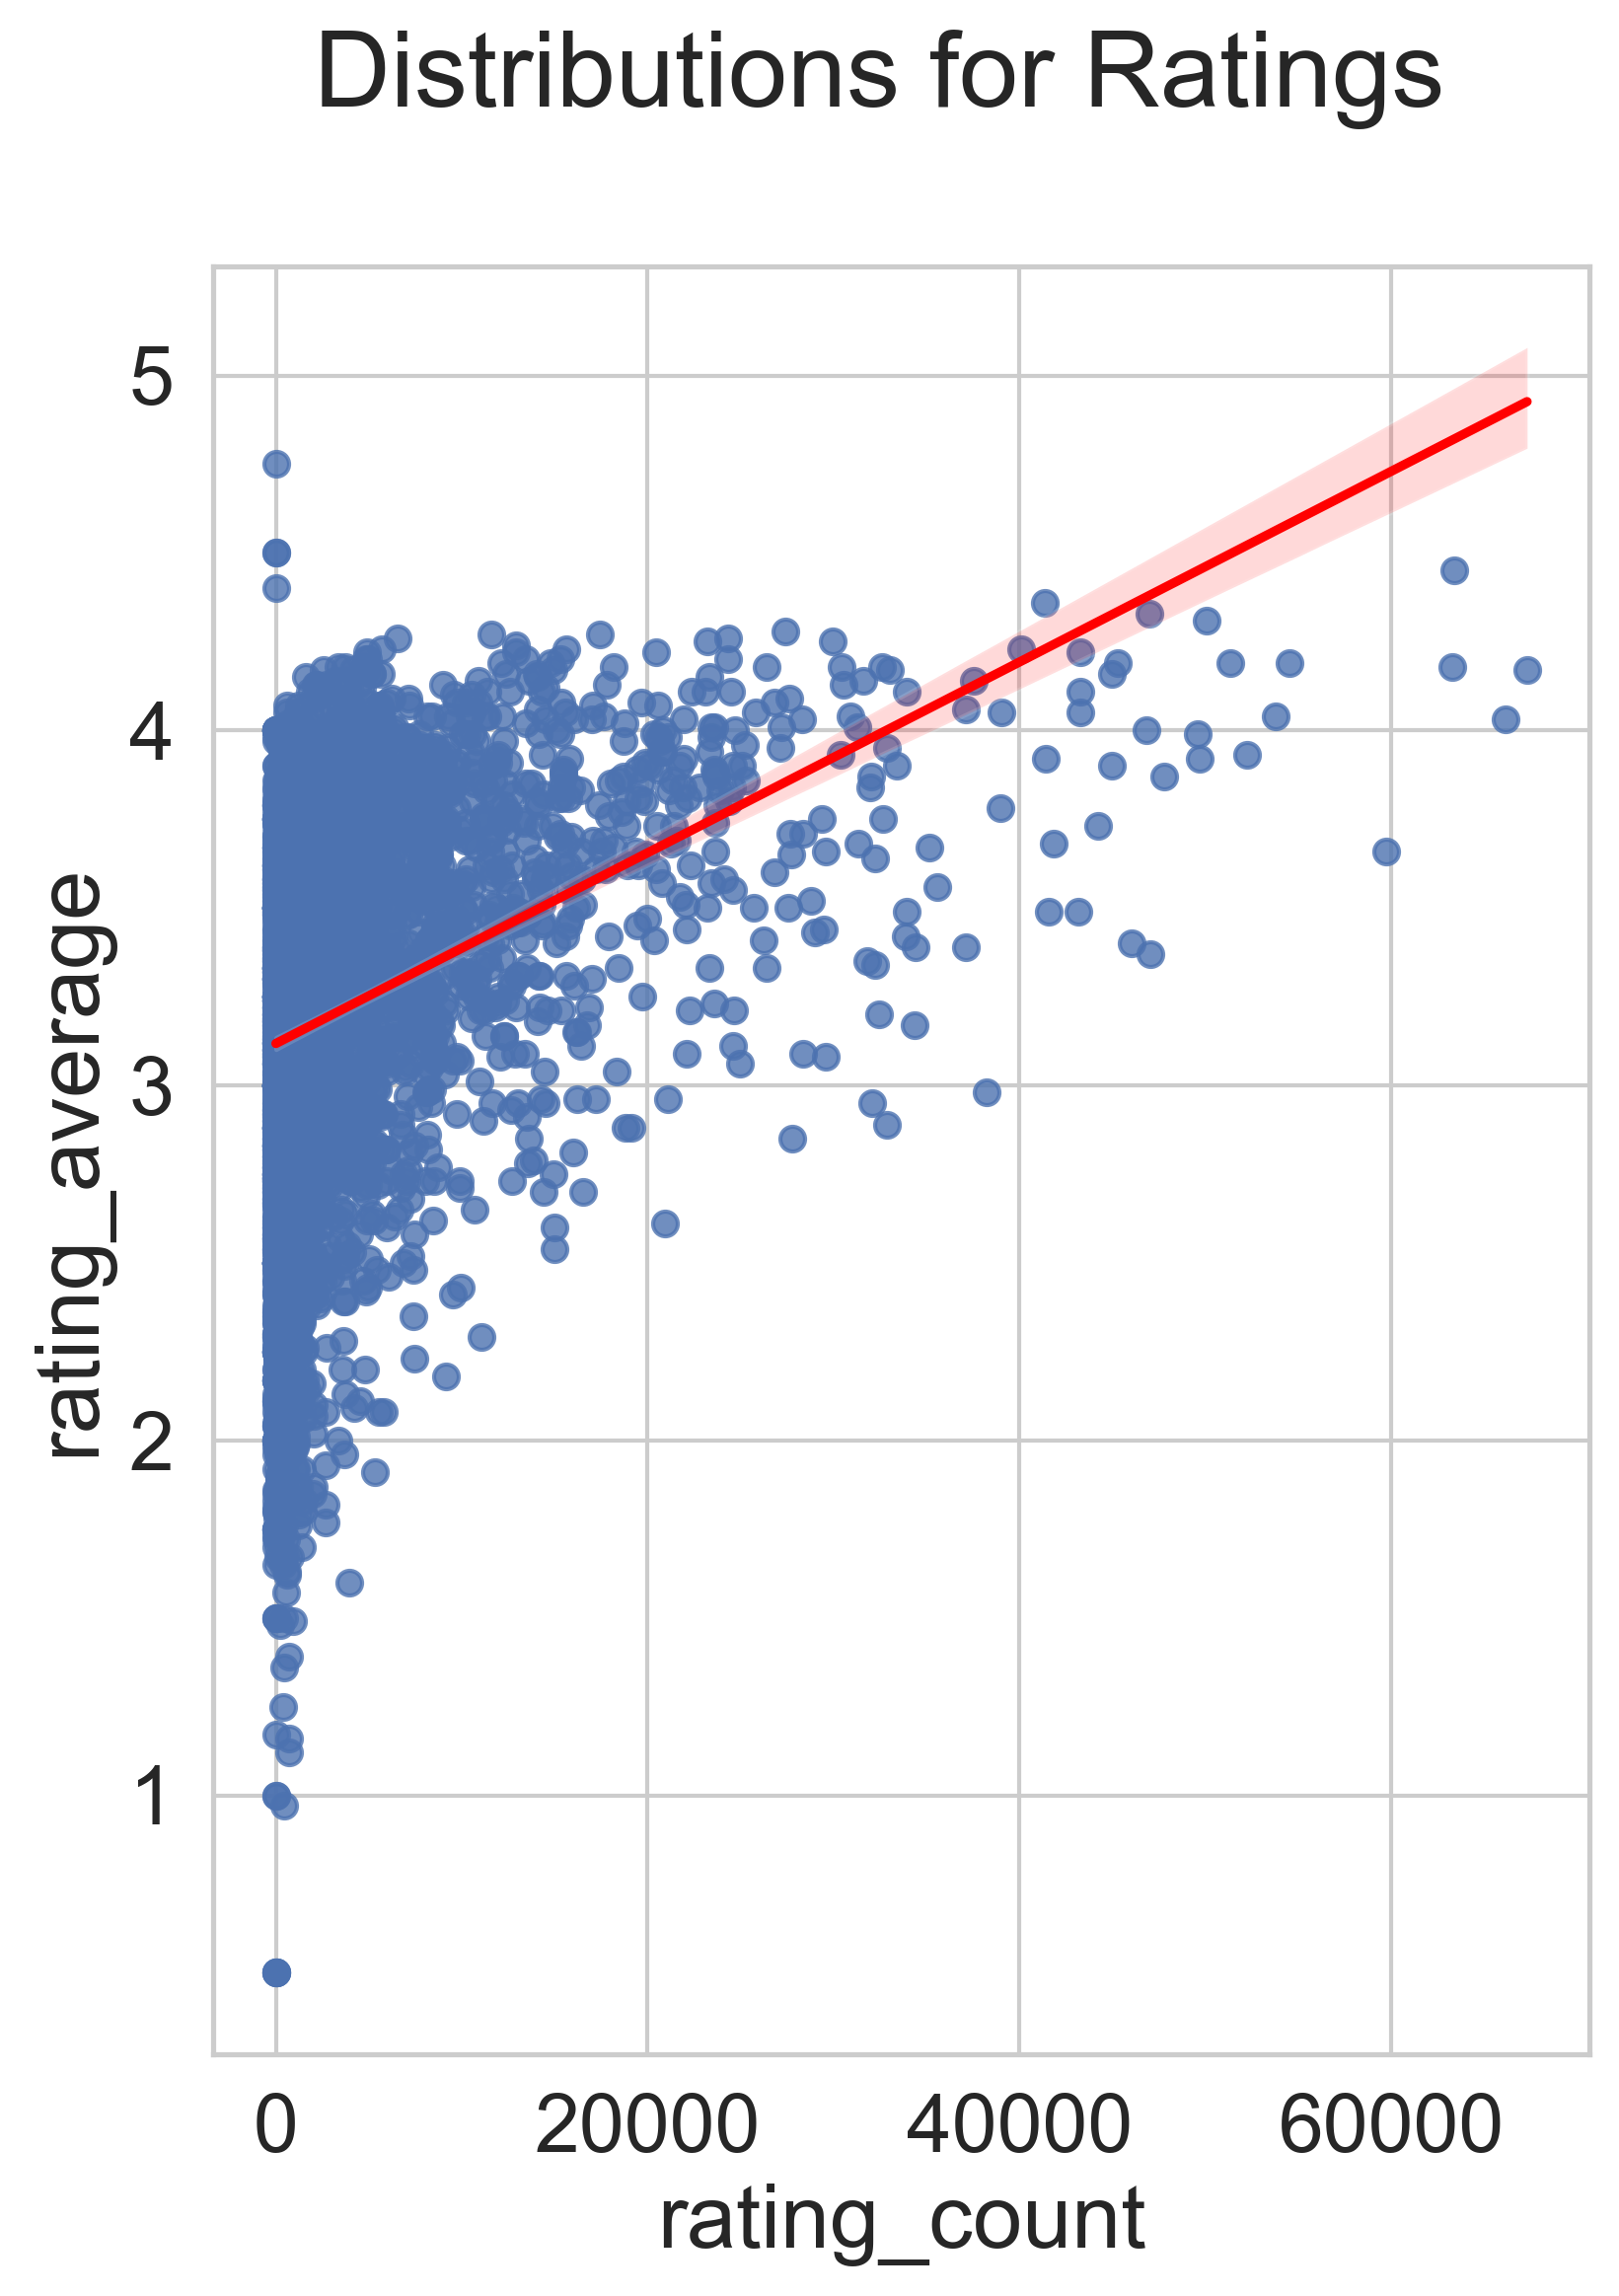

In [123]:
fig, ax = plt.subplots(1,1, figsize = (6,8))
fig.suptitle('Distributions for Ratings')
sns.regplot( x= df2.rating_count, y = df2.rating_average, line_kws={"color": "red"})



In [44]:
# Cat vs Cat and Cat vs Num correlation functions below. Taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements.iloc[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


In [124]:
categorical = ['original_language','release_year','director','genre']
numerical = ['popularity','runtime','rating_count','rating_average','cast_size','crew_size','net_profit']

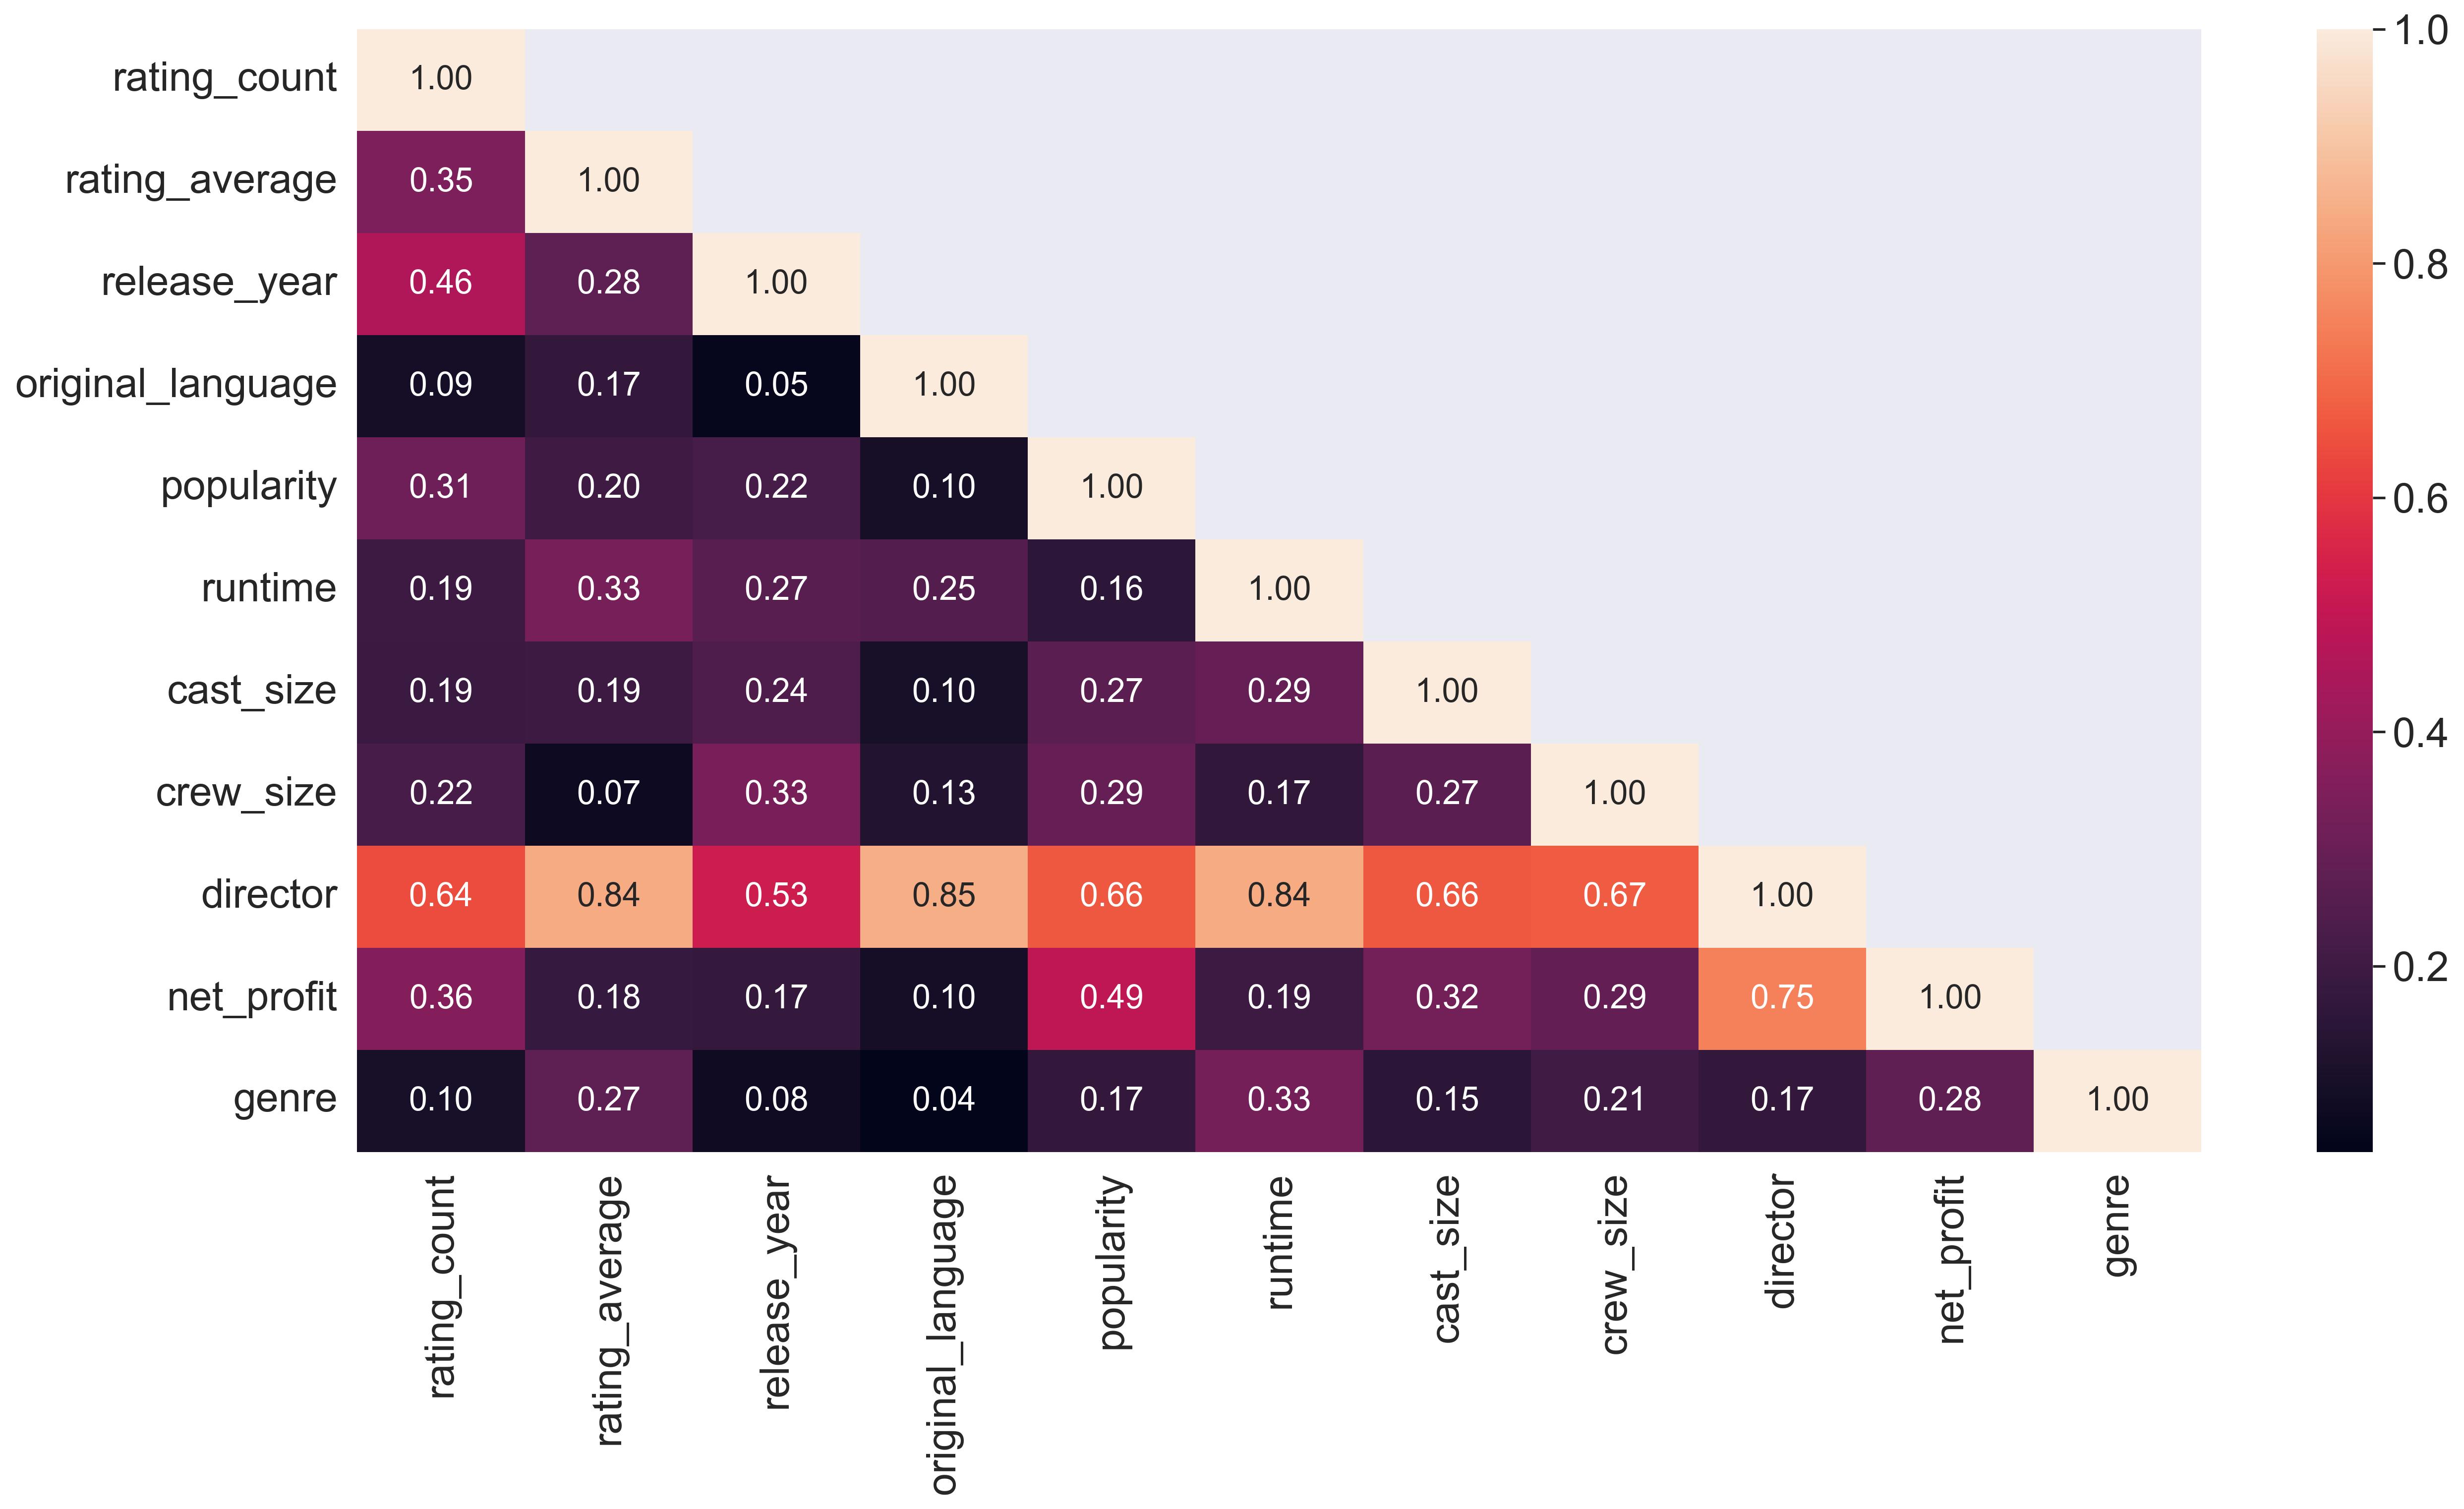

In [126]:
df5 = df4.drop(columns = ['movieId','title','production_companies','production_companiesid','cast','tag','overview'])
columns = df5.columns
corr = pd.DataFrame(index=columns, columns=columns)

for i in range(0, len(columns)):
    for j in range(i, len(columns)):
        
            if i == j:
                corr_factor = 1.0
                
            elif (columns[i] in categorical) and ((columns[j] in categorical)):
                corr_factor =  cramers_v(df5[columns[j]], df5[columns[i]])
            
            elif (columns[i] in numerical) and (columns[j] in numerical):
                corr_factor, pvalue = pearsonr(df5[columns[j]], df5[columns[i]])
                if pvalue > 0.05:
                    corr_factor = np.nan
            
            elif (columns[i] in numerical) and ((columns[j] in categorical)):
                corr_factor =  correlation_ratio(df5[columns[j]], df5[columns[i]])
                if pvalue > 0.05:
                    corr_factor = np.nan
                
            else:
                corr_factor =  correlation_ratio(df5[columns[i]], df5[columns[j]])
                if pvalue > 0.05:
                    corr_factor = np.nan
                
            corr.loc[columns[j],columns[i]] = corr_factor
    
corr.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,10))
sns.set(font_scale=1.8) 
sns.heatmap(corr,annot=True,fmt='.2f',annot_kws={"size": 16})
plt.show()    

In [47]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#tfidf = TfidfVectorizer(stop_words = 'english')
#df2['overview'] = df2['overview'].fillna('')
#fidf_matrix = tfidf.fit_transform(df2['overview'])
#cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [48]:
# Get recommendation function credited to Ibtesam Ahmed and her Kaggle post on: 
# https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

#indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [49]:
#get_recommendations('The Shawshank Redemption')

4233               Escape Plan
2427                    Prison
439             Cool Hand Luke
2439                  Fortress
2575    The 40 Year Old Virgin
1115          Fatal Attraction
1289           American Gigolo
182                  No Escape
1576           Johnny Handsome
2537          The Longest Yard
Name: title, dtype: object

In [50]:
df2 = df1.merge(tagsdf, how = 'left', on = ['movieId'])
df2.rating_average = df2.rating_average.round(2)
df2.rename(columns = {'timestamp': 'date'}, inplace = True)
df2.drop(columns = ['imdbId','tmdbId'], inplace = True)
pd.options.display.float_format = '{:20,.2f}'.format
df2.popularity = df2.popularity.astype(float)
df2.popularity = round(df2.popularity,2)
df2 = df2.fillna("")



In [51]:
columns = ['cast','genres', 'production_companies','tag','director']
def lower(x):
    if isinstance(x,list):
        return [str.lower(i) for i in x]
    else:
        if isinstance(x,str):
            return str.lower(x)
        else:
            return ''

for i in columns:
    df2[i] = df2[i].apply(lower)

In [52]:
def create_soup(x):
    return ' '.join(x['tag']) + ' '+ ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)
df2['soup'] = df2['soup'].str.replace(r'[^\w\s]+', '')

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(df2.soup)
cosine_sim = cosine_similarity(count_matrix)

In [54]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index = df2.title)

In [137]:
get_recommendations('The Shawshank Redemption', cosine_sim)

316     Around the World in Eighty Days
429                    The Great Escape
2797                       The Departed
2639                          King Kong
25                                Se7en
545                      Kiss the Girls
318        Mr. Smith Goes to Washington
3009                           The Mist
3414                    Sherlock Holmes
964               The War of the Worlds
Name: title, dtype: object

In [142]:
get_recommendations('The Count of Monte Cristo')

3901    Journey 2: The Mysterious Island
1162                       Patriot Games
2241                  The China Syndrome
3121                  Death Defying Acts
166                           Free Willy
2551                   War of the Worlds
1290                The Guns of Navarone
497                                Metro
2884                      Starter for 10
2406                        Major Dundee
Name: title, dtype: object

In [138]:
get_recommendations('Avatar')

3068                              The Dark Knight
182                                     No Escape
3860                        The Dark Knight Rises
2359                             Raise Your Voice
585                                       Titanic
1497                                 Pearl Harbor
4138                      Star Trek Into Darkness
2945    Harry Potter and the Order of the Phoenix
1997        The League of Extraordinary Gentlemen
2780                                    Idiocracy
Name: title, dtype: object

In [58]:
#df2.to_csv('content.csv',index = False)

In [59]:
#pd.read_csv('content.csv')